# Predictions of WG, CV and night PPGR from dietary and personal features

In this notebook I will build a predictive model for three measurements: Wakeup glucose (WG), CV of the night and PPGR of the night.
Predictive features I want to use will be daily nutritional data, personal data (age, gender, BMI, waist circumference) and blood tests:
- CRP
- lipid profile including triglycerides, HDL, LDL, cholesterol, cholesterol/HDL, Triglycerides/HDL 
- creatinine for kidney function
- AST, ALL, GGT, Alkaline Phosphatase for liver function

## Imports

In [2]:
import pandas as pd
from LabData.DataLoaders.CGMLoader import CGMLoader
from LabData.DataLoaders.DietLoggingLoader import DietLoggingLoader
from LabData.DataLoaders.SubjectLoader import SubjectLoader
from LabData.DataLoaders.BodyMeasuresLoader import BodyMeasuresLoader
from LabData.DataLoaders.BloodTestsLoader import BloodTestsLoader
import datetime
%matplotlib inline
cgml = CGMLoader()
dll = DietLoggingLoader()

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
import graphviz

## Preparing predictive features

### Personal features of PNP3 participants

Age and gender are in the SubjectLoader. Gender map: 1 - male, 0 - female. 

In the body measurments we have systolic and diastolic blood pressure, weight, BMI, hips, waist, height.
IIn the blood tests I can take all besides A1C, Fructosamine and fasting glucose.

Columns to exclude from the blood tests: 'bt__hba1c', 'bt__glucose', 'bt__fructosamine',  'bt__insulin'

Since the measurements were conducted several times I will take the average over all non zero and non NaN values per person. I can first look if the predictions will work at all. If they don't work a more sofisticated approach will also not help. But! If predictions will work good, then I could think about improving this method.

In [8]:
sl = SubjectLoader()
participants = sl.get_data(study_ids=3).df

bml = BodyMeasuresLoader()
body_meas = bml.get_data(study_ids=3).df

btl = BloodTestsLoader()
blood_tests = btl.get_data(study_ids=3).df

In [13]:
def calc_mean_per_person(df, nans_limit=30):
    
    """This function correctly filters for the columns with enough measurments in them and calculates means per person"""
    
    # df = df.dropna(axis=1, how='all')
    # Zeros disturb the correct calculation of the mean, NaNs do not
    df = df.replace(0, np.NaN)
    df = df.reset_index()
    df_means = df.drop(columns=['Date']).groupby('RegistrationCode').mean()
    # Some columns include too many NaN values, nans_limit was determined manually
    sum_nans = df_means.isnull().sum().rename('sum').to_frame()
    too_many_nans = sum_nans[sum_nans['sum'] > nans_limit].index
    df_means = df_means.drop(columns=too_many_nans)
    df_means = df_means.dropna(axis=0, how='any')
    
    return df_means

In [14]:
body_meas_means = calc_mean_per_person(body_meas)

blood_tests_means = calc_mean_per_person(blood_tests)

blood_tests_means = blood_tests_means.drop(columns=['bt__hba1c', 'bt__glucose', 'bt__fructosamine',  'bt__insulin'])

In [15]:
blood_tests_means.columns

Index(['bt__albumin', 'bt__basophils_%', 'bt__creatinine', 'bt__hemoglobin',
       'bt__mean_platelet_volume', 'bt__wbc', 'bt__crp_synthetic',
       'bt__ast_got', 'bt__mcv', 'bt__total_cholesterol', 'bt__monocytes_%',
       'bt__crp_hs', 'bt__rbc', 'bt__lymphocytes_%', 'bt__hct',
       'bt__ldl_cholesterol', 'bt__triglycerides', 'bt__mch',
       'bt__hdl_cholesterol', 'bt__rdw', 'bt__mchc', 'bt__tsh',
       'bt__platelets', 'bt__neutrophils_%', 'bt__eosinophils_%',
       'bt__alt_gpt'],
      dtype='object')

In [16]:
def merge_all_personal_data(bt_means, bm_means, participants):
    bm_bt = pd.merge(bm_means, bt_means, on='RegistrationCode')
    participants = participants.reset_index('Date')
    pers_data = pd.merge(bm_bt, participants[['age', 'gender']], on='RegistrationCode')
    return pers_data

In [17]:
pers_data = merge_all_personal_data(blood_tests_means, body_meas_means, participants)

pers_data = pers_data.drop(columns='meetingtypeid')

In [19]:
pers_data.head()

,trunk_fat,bmi,sitting_blood_pressure_diastolic,hips,waist,sitting_blood_pressure_pulse_rate,bmr,body_fat,sitting_blood_pressure_systolic,weight,...,bt__hdl_cholesterol,bt__rdw,bt__mchc,bt__tsh,bt__platelets,bt__neutrophils_%,bt__eosinophils_%,bt__alt_gpt,age,gender
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
111527,37.477779,31.204312,88.60,111.000000,90.500000,66.20,1335.555556,40.722223,118.20,72.500000,...,62.300000,14.033333,33.000000,1.21,336.500000,60.333333,2.633333,18.0,49.0,0.0
117111,35.085715,34.287811,89.25,118.333333,116.166667,85.25,2189.857143,32.628571,131.75,108.637498,...,42.966667,12.100000,33.650000,1.84,347.000000,50.825000,4.150000,41.5,49.0,1.0
126092,30.125000,23.415799,94.50,98.000000,80.666667,70.00,1200.375000,33.275000,146.50,59.944444,...,62.625000,12.366667,33.650000,1.60,244.333333,53.050000,2.933333,19.5,58.0,0.0
12752,29.037500,27.268596,97.75,113.000000,100.333333,60.75,2049.625000,26.412500,163.00,95.355555,...,42.400000,12.166667,33.800000,0.59,232.000000,57.466667,3.000000,17.5,58.0,1.0
130279,28.711111,31.145671,77.00,104.875000,101.750000,68.20,1839.333333,26.522222,115.40,86.320000,...,50.500000,11.733333,33.416667,1.03,209.500000,53.483333,2.100000,17.0,58.0,1.0


In [20]:
pers_data.shape

(226, 39)

### Dietary features hourly

In [21]:
def make_hourly_log(nutrient_list, study_ids=3, min_cal_per_day=1000):
    
    """From the raw logdf I get a DataFrame with RC and Date as index and nutritional data aggregated on hourly bases.
    Resulting DataFrame has a column multiindex structure (hour_of_the_day, nutrient)
    """ 
    carbs_cal_per_gram = 4
    fat_cal_per_gram = 9
    prot_cal_per_gram = 4
    
    log = dll.get_data(study_ids=study_ids).df
    logdf = dll.add_nutrients(log, nutrient_list)
    logdf = dll.squeeze_log(logdf)
    logdf = logdf.reset_index()
    logdf['Day'] = logdf['Date'].dt.date
    # Add 1 day to the day column for later correct merge with the features to predict (CV and WG)
    logdf['Day'] = logdf['Day'] + datetime.timedelta(days=1)
    #Identify days with good log more than min_cal_per_day
    totaldaylog = logdf.drop(columns=['meal_type']).groupby(['RegistrationCode', 'Day']).sum()
    totaldaylog = totaldaylog[totaldaylog['energy_kcal'] >= min_cal_per_day]
    days_to_keep = totaldaylog.index
    logdf = logdf.set_index(['RegistrationCode', 'Day'])
    logdf = logdf.loc[days_to_keep]
    logdf['hour'] = logdf['Date'].dt.hour
    # Adding Date to index for correct dropping of the 0 kcal rows
    logdf = logdf.set_index('Date', append=True)
    # Drop rows rows with 0 energy (should be water or tea)
    logdf = logdf.drop(logdf[logdf['energy_kcal'] == 0].index)
    logdf = logdf.reset_index().groupby(['RegistrationCode', 'Day', 'hour']).sum()
    # Add additional features
#     logdf['carbs/lipids'] = logdf['carbohydrate_g'] / logdf['totallipid_g']
    logdf['caloric%carbs'] = logdf['carbohydrate_g'] * carbs_cal_per_gram / logdf['energy_kcal']
    logdf['caloric%fat'] = logdf['totallipid_g'] * fat_cal_per_gram / logdf['energy_kcal']

    # Arrange a data frame in a column multiindex format
    hourly_log = logdf.drop(columns='score').stack().unstack(level=2).unstack(level=-1)
    hourly_log = hourly_log.replace(np.NaN, 0)
    hourly_log.columns.names = (None, None)    
    
    return hourly_log

In [22]:
nutrient_list = ['caffeine_mg', 'carbohydrate_g', 'energy_kcal', 'protein_g', 'sodium_mg', 'sugarstotal_g', 'totaldietaryfiber_g', 'totallipid_g']

40665 person/days in total

In [23]:
hourly_log = make_hourly_log(nutrient_list)

In [24]:
hourly_log.head()

0                                          \
                            weight caffeine_mg carbohydrate_g energy_kcal   
RegistrationCode Day                                                        
111527           2017-10-07    0.0         0.0            0.0         0.0   
                 2017-10-08    0.0         0.0            0.0         0.0   
                 2017-10-09    0.0         0.0            0.0         0.0   
                 2017-11-06    0.0         0.0            0.0         0.0   
                 2017-11-07    0.0         0.0            0.0         0.0   

                                                               \
                            protein_g sodium_mg sugarstotal_g   
RegistrationCode Day                                            
111527           2017-10-07       0.0       0.0           0.0   
                 2017-10-08       0.0       0.0           0.0   
                 2017-10-09       0.0       0.0           0.0   
                 2017-11-06       0.0       0.0           0.0   
                 2017-11-07       0.0       0.0           0.0   

                                                                            \
                            totaldietaryfiber_g totallipid_g caloric%carbs   
RegistrationCode Day                                                         
111527           2017-10-07                 0.0          0.0           0.0   
                 2017-10-08                 0.0          0.0           0.0   
                 2017-10-09                 0.0          0.0           0.0   
                 2017-11-06                 0.0          0.0           0.0   
                 2017-11-07                 0.0          0.0           0.0   

                             ...          23                             \
                             ... caffeine_mg carbohydrate_g energy_kcal   
RegistrationCode Day         ...                                          
111527           2017-10-07  ...         0.0          13.55        95.0   
                 2017-10-08  ...       112.5           0.00         2.5   
                 2017-10-09  ...         0.0           0.00         0.0   
                 2017-11-06  ...         0.0           0.00         0.0   
                 2017-11-07  ...         0.0           0.00         0.0   

                                                               \
                            protein_g sodium_mg sugarstotal_g   
RegistrationCode Day                                            
111527           2017-10-07     1.475     45.75           0.0   
                 2017-10-08     0.300     24.20           0.0   
                 2017-10-09     0.000      0.00           0.0   
                 2017-11-06     0.000      0.00           0.0   
                 2017-11-07     0.000      0.00           0.0   

                                                                            \
                            totaldietaryfiber_g totallipid_g caloric%carbs   
RegistrationCode Day                                                         
111527           2017-10-07              0.5575        3.875      0.570526   
                 2017-10-08              0.0000        0.050      0.000000   
                 2017-10-09              0.0000        0.000      0.000000   
                 2017-11-06              0.0000        0.000      0.000000   
                 2017-11-07              0.0000        0.000      0.000000   

                                         
                            caloric%fat  
RegistrationCode Day                     
111527           2017-10-07    0.367105  
                 2017-10-08    0.180000  
                 2017-10-09    0.000000  
                 2017-11-06    0.000000  
                 2017-11-07    0.000000  

[5 rows x 264 columns]

### Dietary features total and timedelta split

In [248]:
def prepare_diet_data(wg_df, nutrient_list, study_ids=[3,49], min_cal_per_day=1000, how='total_diet', daysplithours=[6,12,18]):
    
    """Prepare joint df with wg and dietary features from the day before.
    One can choose to correlate with total diet from the perevious day or with diet split into breakfast, lunch and dinner.
    :param wg_df : wakeup_glucose DataFrame
    :param nutrient_list: list of nutrients to select (for the full list see LabData/DataLoaders/Lists/meal_features.txt)
                                e.g. ['energy_kcal', 'carbohydrate_g', 'protein_g', 'totallipid_g']
                                if None, all nutrients are selected
    :param min_cal_per_day:
    :param how: string, can be 'total_diet' or 'split_diet'. If split_diet is passed, then the day will be split into breakfast,
                        lunch and dinner and the nutrients will be calculated accordingly.
    :param daysplithours: list telling how to split the day 
        
    :return data_df with wg and dietary features to perform the correlations with
    """ 
    carbs_cal_per_gram = 4
    fat_cal_per_gram = 9
    prot_cal_per_gram = 4
    
    log = dll.get_data(study_ids=study_ids).df
    logdf = dll.add_nutrients(log, nutrient_list)
    logdf = dll.squeeze_log(logdf)
    logdf = logdf.reset_index()
    logdf['Day'] = logdf['Date'].dt.date
    #Identify days with good log more than min_cal_per_day
    totaldaylog = logdf.drop(columns=['meal_type']).groupby(['RegistrationCode', 'Day']).sum()
    totaldaylog = totaldaylog[totaldaylog['energy_kcal'] >= min_cal_per_day]
    days_to_keep = totaldaylog.index
    logdf = logdf.set_index(['RegistrationCode', 'Day'])
    logdf = logdf.loc[days_to_keep]
    
    if how == 'total_diet':
        # Add derived  features
        totaldaylog['carbs/lipids'] = totaldaylog['carbohydrate_g'] / totaldaylog['totallipid_g']
        totaldaylog['caloric%carbs'] = totaldaylog['carbohydrate_g'] * carbs_cal_per_gram / totaldaylog['energy_kcal']
        totaldaylog['caloric%fat'] = totaldaylog['totallipid_g'] * fat_cal_per_gram / totaldaylog['energy_kcal']
        # Change dtype to datetime for merge with wg_df
        totaldaylog = totaldaylog.reset_index('Day')
        totaldaylog['Day'] = pd.to_datetime(totaldaylog['Day'])
        # Add day to the current day for merge with correct wg
        totaldaylog['Day'] = totaldaylog['Day'] + datetime.timedelta(days=1)
        data_for_corr = pd.merge(wg_df, totaldaylog, on=['RegistrationCode', 'Day'])
        
    elif how == 'split_diet':
        logdf['alloc'] = ''
        logdf.loc[(logdf['Date'].dt.time >= datetime.time(daysplithours[0], 0, 0)) & 
              (logdf['Date'].dt.time < datetime.time(daysplithours[1], 0, 0)),'alloc'] = 'b'
        logdf.loc[(logdf['Date'].dt.time >= datetime.time(daysplithours[1], 0, 0)) & 
              (logdf['Date'].dt.time < datetime.time(daysplithours[2], 0, 0)),'alloc'] = 'l'
        logdf.loc[(logdf['Date'].dt.time > datetime.time(daysplithours[2], 0, 0)),'alloc'] = 'd' 
        # We are only interested in  food between 6 and 24. Days where people logged food during the night will be out after merge with wg_df
        logdf = logdf[logdf['alloc'] != '']
        splitlog = logdf.reset_index().groupby(['RegistrationCode', 'Day', 'alloc']).sum()
        splitlog = splitlog.unstack(level=-1)
        splitlog.columns = ['_'.join(splitlog.columns[i]) for i in range(len(splitlog.columns))]
        # Add carbs/lipids ration
        splitlog['carbs/lipids_b'] = splitlog['carbohydrate_g_b'] / splitlog['totallipid_g_b']
        splitlog['carbs/lipids_d'] = splitlog['carbohydrate_g_d'] / splitlog['totallipid_g_d']
        splitlog['carbs/lipids_l'] = splitlog['carbohydrate_g_l'] / splitlog['totallipid_g_l']
        # Change dtype to datetime for merge with wg_df        
        splitlog = splitlog.reset_index('Day')
        splitlog['Day'] = pd.to_datetime(splitlog['Day'])
        # Add day to the current day for merge with correct wg
        splitlog['Day'] = splitlog['Day'] + datetime.timedelta(days=1)
        data_for_corr = pd.merge(wg_df, splitlog, on=['RegistrationCode', 'Day'])
        data_for_corr = data_for_corr.fillna(0)
        
    
    return data_for_corr

In [249]:
nutrient_list = ['caffeine_mg', 'carbohydrate_g', 'energy_kcal', 'protein_g', 'sodium_mg', 'sugarstotal_g', 'totaldietaryfiber_g', 'totallipid_g']

In [251]:
data_corr_total = prepare_diet_data(wakeup_glucose, nutrient_list, study_ids=3, 
                                        min_cal_per_day=1000, how='total_diet')

In [274]:
data_corr_total = data_corr_total.set_index('Day', append=True).drop(columns=['wakeup_glucose','score'])

In [306]:
def subtract_mean(df):
    
    """Subtract the mean of the group (based on RC) from each value"""
    
    df_means = df.reset_index().groupby('RegistrationCode').mean()
    # Adding Day column to the means df
    df_means = pd.merge(df.reset_index('Day')['Day'], df_means, on='RegistrationCode').set_index('Day', append=True)

    df_trans = df - df_means
 
    return df_trans

In [309]:
log_total_trans = subtract_mean(data_corr_total)

In [316]:
log_total_trans.shape

(21467, 12)

In [289]:
data_corr_split = prepare_diet_data(wakeup_glucose, nutrient_list, study_ids=3, 
                                        min_cal_per_day=1000, how='split_diet', daysplithours=[6,12,18])

In [312]:
data_corr_split.columns

Index(['Day', 'wakeup_glucose', 'weight_b', 'weight_d', 'weight_l', 'score_b',
       'score_d', 'score_l', 'caffeine_mg_b', 'caffeine_mg_d', 'caffeine_mg_l',
       'carbohydrate_g_b', 'carbohydrate_g_d', 'carbohydrate_g_l',
       'energy_kcal_b', 'energy_kcal_d', 'energy_kcal_l', 'protein_g_b',
       'protein_g_d', 'protein_g_l', 'sodium_mg_b', 'sodium_mg_d',
       'sodium_mg_l', 'sugarstotal_g_b', 'sugarstotal_g_d', 'sugarstotal_g_l',
       'totaldietaryfiber_g_b', 'totaldietaryfiber_g_d',
       'totaldietaryfiber_g_l', 'totallipid_g_b', 'totallipid_g_d',
       'totallipid_g_l', 'carbs/lipids_b', 'carbs/lipids_d', 'carbs/lipids_l'],
      dtype='object')

In [317]:
data_corr_split = data_corr_split.set_index('Day', append=True).drop(columns=['wakeup_glucose', 'score_b', 'score_d', 'score_l'])

In [320]:
log_split_trans = subtract_mean(data_corr_split)

## Features to predict

### Wakeup glucose (6-7 am)

In [30]:
def calculate_wakeup_glucose_pnp3(time_between = [5,7], study_ids=3):    

    """Calculates wakeup glucose in the interval given in time_between 
    depending on the breakfast time"""
    
    # Get the cgm df and combine it with adjusted glucose 
    cgmdf = cgml.get_data(study_ids=study_ids).df
    cgmdf = cgml._remove_first_day_of_connections(cgmdf)
    cgmdf = cgmdf.reset_index()
    cgmdf['hour'] = cgmdf.Date.dt.hour
    cgmdf = cgmdf.set_index('Date')
    cgmdf.index = cgmdf.index.tz_localize(None)
    adj_gluc = pd.read_json('/home/elming/Cache/adj_gl.json')
    adj_gluc['ConnectionID'] = adj_gluc['ConnectionID'].astype(str)
    adj_gluc['GlucoseTimestamp'] = pd.to_datetime(adj_gluc['GlucoseTimestamp'])
    adj_gluc = adj_gluc.rename(columns={'GlucoseTimestamp':'Date'})
    adj_gluc = adj_gluc.set_index(['ConnectionID', 'Date'])
    cgm_adj = pd.merge(cgmdf, adj_gluc['GlucoseAdj50N13_Mm'], on=['ConnectionID', 'Date'])
    cgm_adj = cgm_adj.rename(columns={'GlucoseAdj50N13_Mm':'GlucoseAdj'})

    #  Get the log df 
    log = dll.get_data(study_ids=study_ids).df
    logdf = dll.add_nutrients(log, ['energy_kcal'])
    logdf = dll.squeeze_log(logdf)
    logdf = logdf.reset_index()
    logdf['Day'] = logdf['Date'].dt.date
    
    # Filter out beverages with 0 kcal
    logdf = logdf[logdf['energy_kcal'] != 0]
    
    # Filter out days with first meals earlier than 6 am 
    firstmeals = pd.DataFrame(logdf.groupby(['RegistrationCode', 'Day'])['Date'].first().rename('breakfast_ts'))
    firstmeals = firstmeals[(firstmeals['breakfast_ts'].dt.time > datetime.time(6, 0, 0))]
    
    # Dtype handling. After groupby 'Day' is an object, but I need it to be datetime
    firstmeals = firstmeals.reset_index('Day')
    firstmeals['Day'] = pd.to_datetime(firstmeals['Day'])
    firstmeals = firstmeals.set_index('Day', append=True)
    cgm_adj['Day'] = cgm_adj.index.date
    cgm_adj = cgm_adj.set_index(['RegistrationCode', 'Day'])
    
    # Get cgm and firstmeals ts in one df
    cgm_fm = pd.merge(cgm_adj, firstmeals, on=['RegistrationCode', 'Day'])
    
    # Leave cgm timestamps between 5 and 7 only
    cgm_fm = cgm_fm[(cgm_fm['hour'] >= time_between[0]) & (cgm_fm['hour'] < time_between[1])]
    
    # If breakfast was between 6 and 7 then wakeup glucose is a mean value between 5 and 6, otherwise between 6 and 7
    cgm_fm = cgm_fm[((cgm_fm['hour'] == time_between[0]) & (cgm_fm['breakfast_ts'].dt.hour == time_between[0] + 1)) | 
                    ((cgm_fm['hour'] == time_between[0] + 1) & (cgm_fm['breakfast_ts'].dt.hour >= time_between[1]))]
    wakeup_glucose = pd.DataFrame(cgm_fm.reset_index().groupby(['RegistrationCode', 'Day', 'hour'])['GlucoseAdj'].mean().rename(
                                'wakeup_glucose'))
    wakeup_glucose = wakeup_glucose.reset_index('hour').drop(columns='hour')
    
    return wakeup_glucose

In [32]:
wakeup_glucose = calculate_wakeup_glucose_pnp3()

In [432]:
#wakeup_glucose = wakeup_glucose.reset_index('hour').drop(columns='hour')

In [33]:
wakeup_glucose.head()

wakeup_glucose
RegistrationCode Day                       
111527           2017-11-08      103.071429
                 2017-11-10       98.071429
                 2017-11-11      101.321429
                 2017-11-12      107.071429
                 2017-11-13      106.071429

In [547]:
def z_transform(df, column_to_transform):
    
    """Z score for the group (based on RC) from each value"""
    
    df_means = df.reset_index().groupby('RegistrationCode').mean()
    df_std =  df.reset_index().groupby('RegistrationCode').std()

    df = df.reset_index('Day')

    for rc in df_means.index.unique():
        df.loc[rc][column_to_transform] = df.loc[rc][column_to_transform].apply(lambda x: (x - df_means.loc[rc])/df_std.loc[rc])
        
    return df

In [548]:
def mean_transform(df, column_to_transform):
    
    """Subtract the mean of the group (based on RC) from each value"""
    
    df_means = df.reset_index().groupby('RegistrationCode').mean()
    

    df = df.reset_index('Day')

    for rc in df_means.index.unique():
        df.loc[rc][column_to_transform] = df.loc[rc][column_to_transform].apply(lambda x: x - df_means.loc[rc])
        
    return df

In [167]:
wakeup_glucose_transz = z_transform(wakeup_glucose, 'wakeup_glucose')

In [544]:
wakeup_glucose_trans = mean_transform(wakeup_glucose, 'wakeup_glucose')

In [545]:
wakeup_glucose_trans.head()

,Day,wakeup_glucose
RegistrationCode,,
111527,2017-11-08,2.750189
111527,2017-11-10,-2.249811
111527,2017-11-11,1.000189
111527,2017-11-12,6.750189
111527,2017-11-13,5.750189


In [59]:
wakeup_glucose_trans = wakeup_glucose_trans.set_index('Day', append=True)

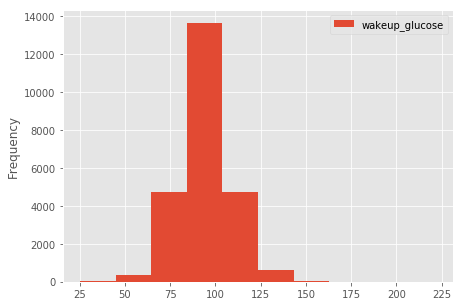

In [164]:
wakeup_glucose.plot.hist(figsize=[7,5])

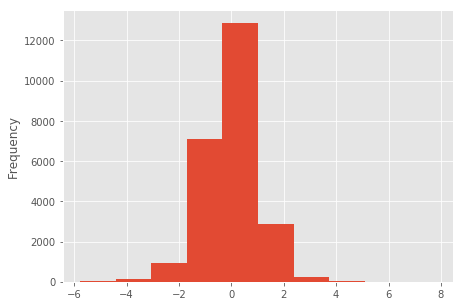

In [170]:
wakeup_glucose_transz['wakeup_glucose'].plot.hist(figsize=[7,5])

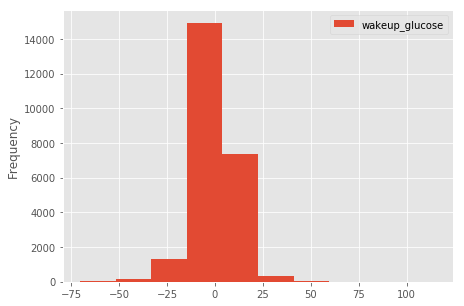

In [163]:
wakeup_glucose_trans.plot.hist(figsize=[7,5])

In [497]:
wakeup_glucose[wakeup_glucose['wakeup_glucose'] < 50] .head(15)

wakeup_glucose
RegistrationCode Day                       
12752            2019-04-04       37.222222
                 2019-04-23       41.428571
132095           2018-06-24       49.545455
147121           2018-12-25       49.500000
173854           2018-10-16       38.500000
                 2018-10-17       43.500000
                 2018-11-07       33.333333
                 2018-11-08       26.333333
                 2018-12-10       41.384615
216303           2019-07-07       35.307692
                 2019-09-02       45.875000
                 2019-09-03       39.875000
225207           2018-03-06       45.375000
243235           2018-07-20       43.743590
                 2018-07-21       40.326923

### Wake up glucose estimated from the sleep data 

In [414]:
from LabData.DataLoaders.SleepLoader import SleepLoader
sl = SleepLoader()
sleep = sl.get_data(study_ids=3).df

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/pandas/core/indexes/base.py:183: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)


In [420]:
def process_sleep_wis(sleep_df):

    sleep_df = sleep_df.reset_index()
    #sleep_df.loc[:, ['RegistrationCode']] = sleep_df.loc[:, 'RegistrationCode'].astype(int).astype(str)
    sleep_df['sleep_time'] = sleep_df['sleep_time'].dt.tz_localize('Asia/Jerusalem',
                                                                   ambiguous='NaT', nonexistent='NaT')
    sleep_df['wakeup_time'] = sleep_df['wakeup_time'].dt.tz_localize('Asia/Jerusalem',
                                                                     ambiguous='NaT', nonexistent='NaT')
    sleep_df = sleep_df.set_index(['RegistrationCode', 'sleep_time'])
    sleep_df = sleep_df[['wakeup_time', 'Quality']]
    return sleep_df


In [422]:
sleep = process_sleep_wis(sleep)

In [423]:
def filter_for_night_sleep(sleep_df, min_sleeping_time=pd.Timedelta(hours=5),
                           max_sleeping_time=pd.Timedelta(hours=10), go_sleep_from = datetime.time(21,0,0),
                           go_sleep_till=datetime.time(3,0,0), wakeup_from=datetime.time(4,0,0),
                           wakeup_till=datetime.time(11,0,0)):
    """
    Filters the raw sleep DataFrame for the night sleeps only
    """
    sleep_df = sleep_df.reset_index('sleep_time')
    sleep_df = sleep_df[['sleep_time', 'wakeup_time']].dropna()
    sleep_df['Duration'] = sleep_df.wakeup_time - sleep_df.sleep_time
    sleep_df = sleep_df[(sleep_df.Duration > min_sleeping_time) & (
                        sleep_df.Duration < max_sleeping_time)]
    sleep_df = sleep_df[
        (sleep_df.sleep_time.dt.time < go_sleep_till) | (sleep_df.sleep_time.dt.time > go_sleep_from)]
    sleep_df = sleep_df[
        (sleep_df.wakeup_time.dt.time > wakeup_from) & (sleep_df.wakeup_time.dt.time < wakeup_till)]
    return sleep_df

In [424]:
sleep = filter_for_night_sleep(sleep)

In [426]:
sleep['Day'] = sleep['wakeup_time'].dt.date
sleep = sleep.set_index('Day', append=True)

sleep_time  \
RegistrationCode Day                                    
2893             2018-11-20 2018-11-20 01:01:15+02:00   
                 2018-11-21 2018-11-21 00:38:42+02:00   
                 2018-11-22 2018-11-22 00:57:31+02:00   
                 2018-11-24 2018-11-24 00:34:25+02:00   
                 2018-11-25 2018-11-25 00:53:08+02:00   
...                                               ...   
997735           2019-07-07 2019-07-06 23:43:39+03:00   
                 2019-07-08 2019-07-07 23:10:59+03:00   
                 2019-07-09 2019-07-08 23:57:59+03:00   
                 2019-07-10 2019-07-09 23:29:01+03:00   
                 2019-07-11 2019-07-11 00:50:04+03:00   

                                          wakeup_time Duration  
RegistrationCode Day                                            
2893             2018-11-20 2018-11-20 06:23:15+02:00 05:22:00  
                 2018-11-21 2018-11-21 06:18:16+02:00 05:39:34  
                 2018-11-22 2018-11-22 06:31:34+02:00 05:34:03  
                 2018-11-24 2018-11-24 08:59:22+02:00 08:24:57  
                 2018-11-25 2018-11-25 06:53:27+02:00 06:00:19  
...                                               ...      ...  
997735           2019-07-07 2019-07-07 07:17:01+03:00 07:33:22  
                 2019-07-08 2019-07-08 07:27:33+03:00 08:16:34  
                 2019-07-09 2019-07-09 07:24:25+03:00 07:26:26  
                 2019-07-10 2019-07-10 07:22:43+03:00 07:53:42  
                 2019-07-11 2019-07-11 08:04:05+03:00 07:14:01  

[20246 rows x 3 columns]

Estimate wake up glucose based on wake up log in the sleep df

In [427]:
cgmdf = cgml.get_data(study_ids=3).df
cgmdf = cgml._remove_first_day_of_connections(cgmdf)

In [429]:
cgmdf = cgmdf.reset_index()
cgmdf = cgmdf.set_index('Date')
cgmdf.index = cgmdf.index.tz_localize(None)
adj_gluc = pd.read_json('/home/elming/Cache/adj_gl.json')
adj_gluc['ConnectionID'] = adj_gluc['ConnectionID'].astype(str)
adj_gluc['GlucoseTimestamp'] = pd.to_datetime(adj_gluc['GlucoseTimestamp'])
adj_gluc = adj_gluc.rename(columns={'GlucoseTimestamp':'Date'})
adj_gluc = adj_gluc.set_index(['ConnectionID', 'Date'])
cgm_adj = pd.merge(cgmdf, adj_gluc['GlucoseAdj50N13_Mm'], on=['ConnectionID', 'Date'])
cgm_adj = cgm_adj.rename(columns={'GlucoseAdj50N13_Mm':'GlucoseAdj'})

In [440]:
cgm_adj = cgm_adj.set_index('RegistrationCode')
sleep = sleep.set_index('RegistrationCode')

In [444]:
cgm_adj = cgm_adj.set_index('Date', append=True)

In [462]:
cgm_adj = cgm_adj.reset_index('RegistrationCode')

In [449]:
sleep['wakeup_time'] = sleep['wakeup_time'].dt.tz_localize(None)

In [466]:
cgm_adj = cgm_adj.sort_index()

In [512]:
wg_from_sleep = pd.merge_asof(cgm_adj.reset_index()[['Date', 'RegistrationCode', 'GlucoseAdj']], sleep['wakeup_time'].sort_values(),  by='RegistrationCode', 
               left_on=['Date'], right_on=['wakeup_time'], direction='forward', tolerance=pd.Timedelta(minutes=30)).dropna(subset=['wakeup_time'])

In [513]:
wg_from_sleep['Day'] = pd.to_datetime(wg_from_sleep['Date'].dt.date)

In [515]:
wg_from_sleep.sort_values(by=['RegistrationCode', 'Day'])

,Date,RegistrationCode,GlucoseAdj,wakeup_time,Day
304162,2017-11-08 05:27:00,111527,99.571429,2017-11-08 05:50:40,2017-11-08
304203,2017-11-08 05:42:00,111527,105.571429,2017-11-08 05:50:40,2017-11-08
308373,2017-11-09 05:39:00,111527,102.571429,2017-11-09 06:04:17,2017-11-09
308420,2017-11-09 05:54:00,111527,104.571429,2017-11-09 06:04:17,2017-11-09
312649,2017-11-10 05:35:00,111527,98.571429,2017-11-10 06:02:34,2017-11-10
...,...,...,...,...,...
2647357,2019-07-07 07:11:00,997735,98.222222,2019-07-07 07:17:01,2019-07-07
2649217,2019-07-08 06:58:00,997735,107.222222,2019-07-08 07:27:33,2019-07-08
2649237,2019-07-08 07:13:00,997735,108.222222,2019-07-08 07:27:33,2019-07-08
2654524,2019-07-11 07:45:00,997735,122.875000,2019-07-11 08:04:05,2019-07-11


In [516]:
wg_from_sleep = wg_from_sleep.groupby(['RegistrationCode', 'Day']).mean().rename(columns={'GlucoseAdj':'wakeup_glucose_sl'})

In [518]:
wg_from_sleep[wg_from_sleep['wakeup_glucose_sl'] < 50]

wakeup_glucose_sl
RegistrationCode Day                          
147121           2018-12-25          47.000000
173854           2018-11-06          48.333333
                 2018-11-07          30.833333
                 2018-12-09          48.884615
                 2018-12-25          47.346154
243235           2018-07-09          38.923077
                 2018-07-20          40.576923
                 2018-10-05          45.285714
313112           2017-07-27          39.692308
381034           2018-11-10          37.111111
394693           2019-01-23          47.100000
43647            2017-12-12          31.250000
456910           2018-09-25          38.555556
494901           2017-07-24          46.000000
                 2017-10-30          38.333333
                 2017-10-31          31.333333
                 2017-11-28          46.900000
56031            2018-04-30          39.227273
573718           2018-05-06          47.600000
682027           2018-11-27          47.000000
                 2019-01-03          46.333333
                 2019-01-04          41.333333
                 2019-01-20          39.000000
                 2019-02-27          47.875000
702207           2019-04-26          45.090909
                 2019-04-28          46.590909
                 2019-05-11          49.333333
745073           2018-09-07          46.769231
885039           2017-12-30          49.423077
922039           2018-08-13          32.538462
                 2018-10-27          45.888889
                 2018-10-28          40.888889
                 2019-03-07          41.888889
946729           2019-04-10          41.423077
948714           2017-12-05          46.333333
954295           2018-05-03          46.583333
963150           2019-02-28          48.769231
997735           2019-06-13          44.954545

In [542]:
wg_compare = pd.merge(wg_from_sleep, wakeup_glucose, on=['RegistrationCode', 'Day']).sample(100)

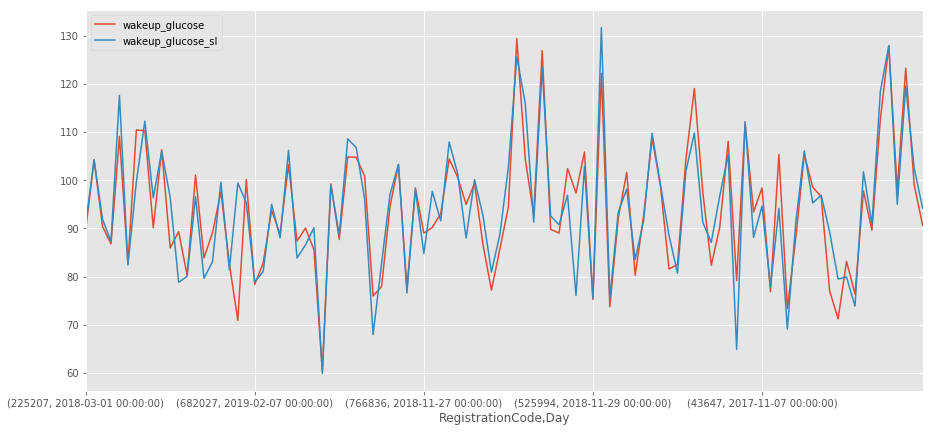

In [543]:
ax = wg_compare['wakeup_glucose'].plot(figsize=[15,7])
wg_compare['wakeup_glucose_sl'].plot(ax=ax)
plt.legend()

In [549]:
wg_sl_trans = mean_transform(wg_from_sleep, 'wakeup_glucose_sl')
wg_sl_trans.head()

,Day,wakeup_glucose_sl
RegistrationCode,,
111527,2017-11-08,3.585934
111527,2017-11-09,4.585934
111527,2017-11-10,0.085934
111527,2017-11-11,0.085934
111527,2017-11-12,-1.414066


### Night CV

In [34]:
def add_gluc_adj_pnp3(study_ids=3):    

    """Get the cgm df and combine it with adjusted glucose"""
     
    cgmdf = cgml.get_data(study_ids=study_ids).df
    cgmdf = cgml._remove_first_day_of_connections(cgmdf)
    cgmdf = cgmdf.reset_index()
    cgmdf['hour'] = cgmdf.Date.dt.hour
    cgmdf = cgmdf.set_index('Date')
    cgmdf.index = cgmdf.index.tz_localize(None)
    adj_gluc = pd.read_json('/home/elming/Cache/adj_gl.json')
    adj_gluc['ConnectionID'] = adj_gluc['ConnectionID'].astype(str)
    adj_gluc['GlucoseTimestamp'] = pd.to_datetime(adj_gluc['GlucoseTimestamp'])
    adj_gluc = adj_gluc.rename(columns={'GlucoseTimestamp':'Date'})
    # adj_gluc = adj_gluc.set_index(['ConnectionID', 'Date'])
    cgm_adj = pd.merge(cgmdf, adj_gluc[['GlucoseAdj50N13_Mm', 'Date', 'ConnectionID']], on=['ConnectionID', 'Date'])
    cgm_adj = cgm_adj.rename(columns={'GlucoseAdj50N13_Mm':'GlucoseAdj'})

    return cgm_adj

In [35]:
cgm_adj = add_gluc_adj_pnp3()

In [36]:
def filter_by_time(df, start, end):
    
    """
    The function filters the cgm entries between certain hours of the day. 
    The output is a dataframe containing the entries between start and end hour of each day.
    :param df: CGM DataFrame
    :param start: string of a type 'hh:mm'
    :param end: string of a type 'hh:mm'
    :return: filtered DataFrame with an index set to 'RegistrationCode', 'Day' and 'Time'
    """

    df = df.set_index('Date')
    filtered_df = df.between_time(start, end)
    pd.options.mode.chained_assignment = None  # to avoid the warning message about chained assignments
    filtered_df['Day'] = filtered_df.index.date

#   From the night cgm adjusted I need to remove nights with less than 16 observations
    count = filtered_df.groupby(['RegistrationCode', 'Day'])['GlucoseAdj'].count()
    rc_days_to_keep = count[count >= 20].index
    filtered_df = filtered_df.set_index(['RegistrationCode', 'Day'])
    filtered_df = filtered_df.loc[rc_days_to_keep]
    
    return filtered_df

In [37]:
night_cgm_adj = filter_by_time(cgm_adj, '00:00', '06:00')

In [38]:
def count_stats(cgm_df):

    f = {'GlucoseAdj': ['mean', 'std']}
    
    stats = cgm_df.groupby(['RegistrationCode', 'Day'])['GlucoseAdj'].agg(f)
    stats.columns = stats.columns.droplevel()
    stats['CV'] = stats['std'] / stats['mean']
    
    return stats

In [39]:
night_cv = count_stats(night_cgm_adj)

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """


In [75]:
night_cv_trans = mean_transform(night_cv['CV'], 'CV').set_index('Day', append=True)

### Night PPGR

In [41]:
night_cgm_adj.head()

ConnectionID  GlucoseValue  PPGR  hour  GlucoseAdj
RegistrationCode Day                                                          
111527           2017-11-08         1926         100.0  0.00     0   98.571429
                 2017-11-08         1926          97.0  0.00     0   95.571429
                 2017-11-08         1926          96.0  0.00     0   94.571429
                 2017-11-08         1926          93.0  1.75     0   91.571429
                 2017-11-08         1926          90.0  9.25     1   88.571429

In [42]:
def calc_mean_night_ppgr(night_cgm, min_timepoints=12):
    
    """Calculates mean PPGR for the nights with more than min_timepoints available (non-NaNs)"""
    
    ppgr_count = pd.DataFrame(night_cgm.reset_index().groupby(['RegistrationCode', 'Day'])['PPGR'].count())
    index_to_keep = ppgr_count[ppgr_count['PPGR'] >= min_timepoints].index
    night_cgm = night_cgm.loc[index_to_keep]
    ppgr = pd.DataFrame(night_cgm.reset_index().groupby(['RegistrationCode', 'Day'])['PPGR'].mean())
    
    return ppgr

In [43]:
ppgr = calc_mean_night_ppgr(night_cgm_adj)

In [51]:
ppgr_trans

,Day,PPGR
RegistrationCode,,
111527,2017-11-08,5.437251
111527,2017-11-09,4.182043
111527,2017-11-10,5.135168
111527,2017-11-11,2.270585
111527,2017-11-12,1.499751
...,...,...
997735,2019-11-02,-0.653999
997735,2019-11-03,-3.117168
997735,2019-11-04,-3.598327


transform PPGR

In [50]:
ppgr_trans = mean_transform(ppgr, 'PPGR')

## Preparing joint DataFrames, transforming values and running predictions 

The idea is now to gradually add dietary data to predictive features and see how predictions are being changed.  
I will start with dietary data from 22 to 00 the day before and in each new round of predictions I will add data for two more hours.

I don't have to transform personal data since I have only one row per person. Maybe I should still transform it though so that the numbers are in the range from -1 to +1 for instance?

In [27]:
pers_data

,trunk_fat,bmi,sitting_blood_pressure_diastolic,hips,waist,sitting_blood_pressure_pulse_rate,bmr,body_fat,sitting_blood_pressure_systolic,weight,...,bt__hdl_cholesterol,bt__rdw,bt__mchc,bt__tsh,bt__platelets,bt__neutrophils_%,bt__eosinophils_%,bt__alt_gpt,age,gender
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
111527,37.477779,31.204312,88.60,111.000000,90.500000,66.200000,1335.555556,40.722223,118.20,72.500000,...,62.300000,14.033333,33.000000,1.210000,336.500000,60.333333,2.633333,18.000000,49.0,0.0
117111,35.085715,34.287811,89.25,118.333333,116.166667,85.250000,2189.857143,32.628571,131.75,108.637498,...,42.966667,12.100000,33.650000,1.840000,347.000000,50.825000,4.150000,41.500000,49.0,1.0
126092,30.125000,23.415799,94.50,98.000000,80.666667,70.000000,1200.375000,33.275000,146.50,59.944444,...,62.625000,12.366667,33.650000,1.600000,244.333333,53.050000,2.933333,19.500000,58.0,0.0
12752,29.037500,27.268596,97.75,113.000000,100.333333,60.750000,2049.625000,26.412500,163.00,95.355555,...,42.400000,12.166667,33.800000,0.590000,232.000000,57.466667,3.000000,17.500000,58.0,1.0
130279,28.711111,31.145671,77.00,104.875000,101.750000,68.200000,1839.333333,26.522222,115.40,86.320000,...,50.500000,11.733333,33.416667,1.030000,209.500000,53.483333,2.100000,17.000000,58.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988899,38.622223,41.442556,105.40,114.500000,129.250000,77.400000,2413.777778,39.388888,141.00,128.533335,...,45.175000,14.040000,34.100000,1.510000,177.600000,58.460000,1.480000,43.000000,39.0,1.0
991569,33.549999,35.398514,89.50,121.000000,114.000000,73.500000,2291.000000,31.100000,133.50,110.900002,...,46.100000,13.800000,33.050000,1.500000,256.500000,52.050000,4.750000,19.000000,54.0,1.0
992638,29.410000,26.424319,93.00,94.500000,93.500000,82.200000,1598.100000,26.450000,133.20,74.580000,...,36.925000,12.316667,33.333333,1.626667,148.833333,62.583333,1.616667,15.000000,56.0,1.0


On the dietary data it is hard to perform Z-score transform as I have many zero columns for some hours. It implies that I have zero standard deviation and can't divide on 0. So, the Z-score transformation results in too many NaNs. I want to try just to subtract the mean of the person from daily data.

In [52]:
diet_mean_transformed = hourly_log.copy(deep=True).reset_index()

diet_mean_transformed.columns.names = (None, None)

means = diet_mean_transformed.drop(columns='Day').groupby('RegistrationCode').mean()
# std = tmpz.drop(columns='Day').groupby('RegistrationCode').std()

diet_mean_transformed = diet_mean_transformed.set_index(['RegistrationCode', 'Day'])

for rc in diet_mean_transformed.reset_index('Day').index.unique():
    df = diet_mean_transformed.loc[(rc, slice(None))] - means.loc[rc]
    df['RegistrationCode'] = rc
    df = df.reset_index().set_index(['RegistrationCode', 'Day'])
    diet_mean_transformed.loc[(rc, slice(None))] = df

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [176]:
diet_pers_dat = pd.merge(hourly_log.reset_index('Day'), pers_data, on='RegistrationCode')

diet_pers_dat = diet_pers_dat.rename(columns={('Day', ''):'Day'})

# rename columns
def rename(col):
    if isinstance(col, tuple):
        col = '_'.join(str(c) for c in col)
    return col
diet_pers_dat.columns = map(rename, diet_pers_dat.columns)

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [552]:
diet_mean_transformed.head()

0                                          \
                              weight caffeine_mg carbohydrate_g energy_kcal   
RegistrationCode Day                                                          
111527           2017-10-07 -0.25641         0.0      -0.030466   -1.247696   
                 2017-10-08 -0.25641         0.0      -0.030466   -1.247696   
                 2017-10-09 -0.25641         0.0      -0.030466   -1.247696   
                 2017-11-06 -0.25641         0.0      -0.030466   -1.247696   
                 2017-11-07 -0.25641         0.0      -0.030466   -1.247696   

                                                               \
                            protein_g sodium_mg sugarstotal_g   
RegistrationCode Day                                            
111527           2017-10-07 -0.024003 -0.045479     -0.002945   
                 2017-10-08 -0.024003 -0.045479     -0.002945   
                 2017-10-09 -0.024003 -0.045479     -0.002945   
                 2017-11-06 -0.024003 -0.045479     -0.002945   
                 2017-11-07 -0.024003 -0.045479     -0.002945   

                                                                            \
                            totaldietaryfiber_g totallipid_g caloric%carbs   
RegistrationCode Day                                                         
111527           2017-10-07           -0.007559    -0.117408     -0.000501   
                 2017-10-08           -0.007559    -0.117408     -0.000501   
                 2017-10-09           -0.007559    -0.117408     -0.000501   
                 2017-11-06           -0.007559    -0.117408     -0.000501   
                 2017-11-07           -0.007559    -0.117408     -0.000501   

                             ...          23                             \
                             ... caffeine_mg carbohydrate_g energy_kcal   
RegistrationCode Day         ...                                          
111527           2017-10-07  ...   -1.210769      13.354995   93.030195   
                 2017-10-08  ...  111.289231      -0.195005    0.530195   
                 2017-10-09  ...   -1.210769      -0.195005   -1.969805   
                 2017-11-06  ...   -1.210769      -0.195005   -1.969805   
                 2017-11-07  ...   -1.210769      -0.195005   -1.969805   

                                                                \
                            protein_g  sodium_mg sugarstotal_g   
RegistrationCode Day                                             
111527           2017-10-07   1.44281  44.582256     -0.064853   
                 2017-10-08   0.26781  23.032256     -0.064853   
                 2017-10-09  -0.03219  -1.167744     -0.064853   
                 2017-11-06  -0.03219  -1.167744     -0.064853   
                 2017-11-07  -0.03219  -1.167744     -0.064853   

                                                                            \
                            totaldietaryfiber_g totallipid_g caloric%carbs   
RegistrationCode Day                                                         
111527           2017-10-07             0.55341     3.791087      0.560894   
                 2017-10-08            -0.00409    -0.033913     -0.009632   
                 2017-10-09            -0.00409    -0.083913     -0.009632   
                 2017-11-06            -0.00409    -0.083913     -0.009632   
                 2017-11-07            -0.00409    -0.083913     -0.009632   

                                         
                            caloric%fat  
RegistrationCode Day                     
111527           2017-10-07    0.358906  
                 2017-10-08    0.171801  
                 2017-10-09   -0.008199  
                 2017-11-06   -0.008199  
                 2017-11-07   -0.008199  

[5 rows x 264 columns]

In [557]:
diet_trans_pers_dat = pd.merge(diet_mean_transformed.reset_index('Day'), pers_data, on='RegistrationCode')

diet_trans_pers_dat = diet_trans_pers_dat.rename(columns={('Day', ''):'Day'})

# rename columns
def rename(col):
    if isinstance(col, tuple):
        col = '_'.join(str(c) for c in col)
    return col
diet_trans_pers_dat.columns = map(rename, diet_trans_pers_dat.columns)

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


### Predict wg df

In [179]:
wg_pred_df = pd.merge(diet_pers_dat, wakeup_glucose, on=['RegistrationCode', 'Day']).set_index('Day', append=True)

In [217]:
wg_pred_df.iloc[:,:-40]

0_weight  0_caffeine_mg  0_carbohydrate_g  \
RegistrationCode Day                                                     
111527           2017-11-08       0.0            0.0               0.0   
                 2017-11-10       0.0            0.0               0.0   
                 2017-11-11       0.0            0.0               0.0   
                 2017-11-12       0.0            0.0               0.0   
                 2017-11-13       0.0            0.0               0.0   
...                               ...            ...               ...   
997735           2019-07-18       0.0            0.0               0.0   
                 2019-07-19       0.0            0.0               0.0   
                 2019-07-20       0.0            0.0               0.0   
                 2019-07-21       0.0            0.0               0.0   
                 2019-11-03       0.0            0.0               0.0   

                             0_energy_kcal  0_protein_g  0_sodium_mg  \
RegistrationCode Day                                                   
111527           2017-11-08            0.0          0.0          0.0   
                 2017-11-10            0.0          0.0          0.0   
                 2017-11-11            0.0          0.0          0.0   
                 2017-11-12            0.0          0.0          0.0   
                 2017-11-13            0.0          0.0          0.0   
...                                    ...          ...          ...   
997735           2019-07-18            0.0          0.0          0.0   
                 2019-07-19            0.0          0.0          0.0   
                 2019-07-20            0.0          0.0          0.0   
                 2019-07-21            0.0          0.0          0.0   
                 2019-11-03            0.0          0.0          0.0   

                             0_sugarstotal_g  0_totaldietaryfiber_g  \
RegistrationCode Day                                                  
111527           2017-11-08              0.0                    0.0   
                 2017-11-10              0.0                    0.0   
                 2017-11-11              0.0                    0.0   
                 2017-11-12              0.0                    0.0   
                 2017-11-13              0.0                    0.0   
...                                      ...                    ...   
997735           2019-07-18              0.0                    0.0   
                 2019-07-19              0.0                    0.0   
                 2019-07-20              0.0                    0.0   
                 2019-07-21              0.0                    0.0   
                 2019-11-03              0.0                    0.0   

                             0_totallipid_g  0_caloric%carbs  ...  \
RegistrationCode Day                                          ...   
111527           2017-11-08             0.0              0.0  ...   
                 2017-11-10             0.0              0.0  ...   
                 2017-11-11             0.0              0.0  ...   
                 2017-11-12             0.0              0.0  ...   
                 2017-11-13             0.0              0.0  ...   
...                                     ...              ...  ...   
997735           2019-07-18             0.0              0.0  ...   
                 2019-07-19             0.0              0.0  ...   
                 2019-07-20             0.0              0.0  ...   
                 2019-07-21             0.0              0.0  ...   
                 2019-11-03             0.0              0.0  ...   

                             23_caffeine_mg  23_carbohydrate_g  \
RegistrationCode Day                                             
111527           2017-11-08             0.0                0.0   
                 2017-11-10             0.0                0.0   
                 2017-11-11             0.0

In [182]:
# wg_pred_df.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
wg_pred_df.columns

Index(['0_weight', '0_caffeine_mg', '0_carbohydrate_g', '0_energy_kcal',
       '0_protein_g', '0_sodium_mg', '0_sugarstotal_g',
       '0_totaldietaryfiber_g', '0_totallipid_g', '0_caloric%carbs',
       ...
       'bt__rdw', 'bt__mchc', 'bt__tsh', 'bt__platelets', 'bt__neutrophils_%',
       'bt__eosinophils_%', 'bt__alt_gpt', 'age', 'gender', 'wakeup_glucose'],
      dtype='object', length=304)

In [338]:
def predict_value(value_df, diet_pers_dat, n_2h_rounds=1, start_loc=242, end_loc=-1, random_state=383, learning_rate = 0.1,
                    max_depth = 6, n_estimators = 100):
    
    value_pred_df = pd.merge(diet_pers_dat, value_df, on=['RegistrationCode', 'Day']).set_index('Day', append=True)

    for i in range(n_2h_rounds):
        start = start_loc - 22*i
        X,y = value_pred_df.iloc[:,start:end_loc], pd.DataFrame(value_pred_df.iloc[:,-1])
        # print(X.iloc[0,:], y.iloc[0])
        X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=random_state)
        xgbr = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate =learning_rate,
                    max_depth = max_depth, n_estimators = n_estimators) 

        xgbr.fit(X_train, y_train)

        kfold = KFold(n_splits=3, shuffle=True)
        kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
        print("Round %d K-fold CV average score: %.2f" % (i, kf_cv_scores.mean()))

In [207]:
predict_value(wakeup_glucose, diet_pers_dat, n_2h_rounds=3, end_loc=-38, max_depth=5)

Round 0 K-fold CV average score: 0.40
Round 1 K-fold CV average score: 0.38
Round 2 K-fold CV average score: 0.37


In [216]:
#predicting from only two columns: trunk fat and BMI
predict_value(wakeup_glucose, diet_pers_dat, n_2h_rounds=1, start_loc=-40, end_loc=-38, max_depth=5)

Round 0 K-fold CV average score: 0.44


In [184]:
predict_value(wakeup_glucose_trans, diet_pers_dat)

Round 0 K-fold CV average score: -0.01


In [185]:
predict_value(wakeup_glucose_transz, diet_pers_dat)

Round 0 K-fold CV average score: -0.02


**Predict from the total log and personal features**

In [324]:
total_diet_pers_f = pd.merge(log_total_trans.reset_index('Day'), pers_data, on='RegistrationCode')

In [339]:
predict_value(wakeup_glucose_trans, total_diet_pers_f, n_2h_rounds=1, start_loc=0, end_loc=-1, random_state=383, learning_rate = 0.1,
                    max_depth = 5, n_estimators = 100)

Round 0 K-fold CV average score: -0.01


**Predict from the split log and personal features**

In [329]:
split_diet_pers_f = pd.merge(log_split_trans.reset_index('Day'), pers_data, on='RegistrationCode')

In [340]:
predict_value(wakeup_glucose_trans, split_diet_pers_f, n_2h_rounds=1, start_loc=0, end_loc=-1, random_state=383, learning_rate = 0.1,
                    max_depth = 5, n_estimators = 100)

Round 0 K-fold CV average score: -0.01


### Predict wg estimated from sleep data

In [551]:
predict_value(wg_sl_trans, diet_pers_dat, n_2h_rounds=3, end_loc=-1, max_depth=5)

Round 0 K-fold CV average score: -0.04
Round 1 K-fold CV average score: -0.02
Round 2 K-fold CV average score: -0.03


In [558]:
predict_value(wg_sl_trans, diet_trans_pers_dat, n_2h_rounds=3, end_loc=-1, max_depth=5)

Round 0 K-fold CV average score: -0.03
Round 1 K-fold CV average score: -0.03
Round 2 K-fold CV average score: -0.03


### Predict cv df

In [81]:
cv_pred_df = pd.merge(diet_pers_dat, night_cv['CV'], on=['RegistrationCode', 'Day']).set_index('Day', append=True)

In [559]:
cv_pred_df.head()

(0, weight)  (0, caffeine_mg)  \
RegistrationCode Day                                         
111527           2017-11-08     -0.25641               0.0   
                 2017-11-09     -0.25641               0.0   
                 2017-11-10     -0.25641               0.0   
                 2017-11-11     -0.25641               0.0   
                 2017-11-12     -0.25641               0.0   

                             (0, carbohydrate_g)  (0, energy_kcal)  \
RegistrationCode Day                                                 
111527           2017-11-08            -0.030466         -1.247696   
                 2017-11-09            -0.030466         -1.247696   
                 2017-11-10            -0.030466         -1.247696   
                 2017-11-11            -0.030466         -1.247696   
                 2017-11-12            -0.030466         -1.247696   

                             (0, protein_g)  (0, sodium_mg)  \
RegistrationCode Day                                          
111527           2017-11-08       -0.024003       -0.045479   
                 2017-11-09       -0.024003       -0.045479   
                 2017-11-10       -0.024003       -0.045479   
                 2017-11-11       -0.024003       -0.045479   
                 2017-11-12       -0.024003       -0.045479   

                             (0, sugarstotal_g)  (0, totaldietaryfiber_g)  \
RegistrationCode Day                                                        
111527           2017-11-08           -0.002945                 -0.007559   
                 2017-11-09           -0.002945                 -0.007559   
                 2017-11-10           -0.002945                 -0.007559   
                 2017-11-11           -0.002945                 -0.007559   
                 2017-11-12           -0.002945                 -0.007559   

                             (0, totallipid_g)  (0, caloric%carbs)  ...  \
RegistrationCode Day                                                ...   
111527           2017-11-08          -0.117408           -0.000501  ...   
                 2017-11-09          -0.117408           -0.000501  ...   
                 2017-11-10          -0.117408           -0.000501  ...   
                 2017-11-11          -0.117408           -0.000501  ...   
                 2017-11-12          -0.117408           -0.000501  ...   

                               bt__rdw  bt__mchc  bt__tsh  bt__platelets  \
RegistrationCode Day                                                       
111527           2017-11-08  14.033333      33.0     1.21          336.5   
                 2017-11-09  14.033333      33.0     1.21          336.5   
                 2017-11-10  14.033333      33.0     1.21          336.5   
                 2017-11-11  14.033333      33.0     1.21          336.5   
                 2017-11-12  14.033333      33.0     1.21          336.5   

                             bt__neutrophils_%  bt__eosinophils_%  \
RegistrationCode Day                                                
111527           2017-11-08          60.333333           2.633333   
                 2017-11-09          60.333333           2.633333   
                 2017-11-10          60.333333           2.633333   
                 2017-11-11          60.333333           2.633333   
                 2017-11-12          60.333333           2.633333   

                             bt__alt_gpt   age  gender        CV  
RegistrationCode Day                                              
111527           2017-11-08         18.0  49.0     0.0  0.064114  
                 2017-11-09         18.0  49.0     0.0  0.066621  
                 2017-11-10         18.0  49.0     0.0  0.057958  
                 2017-11-11         18.0  49.0     0.0  0.101566  
                 2017-11-12         18.0  49.0     0.0  0.027621  

[5 rows x 304 columns]

In [67]:
cv_pred_df.shape

(23502, 304)

In [218]:
predict_value(night_cv['CV'], diet_pers_dat, n_2h_rounds=3, end_loc=-40, max_depth=5)

Round 0 K-fold CV average score: 0.05
Round 1 K-fold CV average score: 0.09
Round 2 K-fold CV average score: 0.10


In [219]:
predict_value(night_cv['CV'], diet_pers_dat, n_2h_rounds=3, end_loc=-38, max_depth=5)

Round 0 K-fold CV average score: 0.14
Round 1 K-fold CV average score: 0.15
Round 2 K-fold CV average score: 0.14


In [220]:
predict_value(night_cv['CV'], diet_pers_dat, n_2h_rounds=3, end_loc=-1, max_depth=5)

Round 0 K-fold CV average score: 0.16
Round 1 K-fold CV average score: 0.19
Round 2 K-fold CV average score: 0.19


In [254]:
predict_value(night_cv['CV'], diet_pers_dat, n_2h_rounds=1, start_loc=-38, end_loc=-1, max_depth=5)

Round 0 K-fold CV average score: 0.12


### Predict ppgr df

In [64]:
ppgr_pred_df = pd.merge(diet_pers_dat, ppgr_trans, on=['RegistrationCode', 'Day']).set_index('Day', append=True)

In [65]:
ppgr_pred_df.shape

(22878, 304)

In [246]:
# from food only
predict_value(ppgr_trans, diet_pers_dat, n_2h_rounds=3, end_loc=-40, max_depth=5)

Round 0 K-fold CV average score: -0.02
Round 1 K-fold CV average score: -0.02
Round 2 K-fold CV average score: -0.03


In [225]:
# from food only
predict_value(ppgr, diet_pers_dat, n_2h_rounds=3, end_loc=-40, max_depth=5)

Round 0 K-fold CV average score: -0.01
Round 1 K-fold CV average score: -0.02
Round 2 K-fold CV average score: -0.01


In [ ]:
predict_value(ppgr, diet_pers_dat, n_2h_rounds=3, end_loc=-38, max_depth=5)

Round 0 K-fold CV average score: 0.09
Round 1 K-fold CV average score: 0.07


In [224]:
predict_value(ppgr, diet_pers_dat, n_2h_rounds=2, end_loc=-1, max_depth=5)

Round 0 K-fold CV average score: 0.12
Round 1 K-fold CV average score: 0.11


In [247]:
predict_value(ppgr_trans, diet_pers_dat, n_2h_rounds=3, end_loc=-1, max_depth=5)

Round 0 K-fold CV average score: -0.02
Round 1 K-fold CV average score: -0.02
Round 2 K-fold CV average score: -0.02


### Predict wg from CV/PPGR of the night

In [233]:
wg_cv_trans = pd.merge(night_cv_trans, wakeup_glucose_trans, on=['RegistrationCode', 'Day'])

In [242]:
wg_cv_ppgr_trans = pd.merge(ppgr_trans, wg_cv_trans, on=['RegistrationCode', 'Day'])

In [237]:
predict_value(wg_cv_trans, diet_pers_dat, n_2h_rounds=1, end_loc=-1, max_depth=3)

Round 0 K-fold CV average score: 0.03


In [243]:
predict_value(wg_cv_ppgr_trans, diet_pers_dat, n_2h_rounds=1,start_loc=-5, end_loc=-1, max_depth=3)

Round 0 K-fold CV average score: 0.09


I can explain 10 % of the variance predicting relative wg differences from relative CV and PPGR differences of the night time.

Make diet_pers_dat_trans

In [245]:
predict_value(wg_cv_ppgr_trans, diet_pers_dat, n_2h_rounds=3, end_loc=-1, max_depth=5)

Round 0 K-fold CV average score: 0.10
Round 1 K-fold CV average score: 0.09
Round 2 K-fold CV average score: 0.10


In [256]:
predict_value(wg_cv_ppgr_trans, diet_pers_dat, n_2h_rounds=1,start_loc=-3, end_loc=-1, max_depth=3)

Round 0 K-fold CV average score: 0.08


### Selection of people with relatively high value of average wake up glucose

In [257]:
wakeup_glucose.head()

wakeup_glucose
RegistrationCode Day                       
111527           2017-11-08      103.071429
                 2017-11-10       98.071429
                 2017-11-11      101.321429
                 2017-11-12      107.071429
                 2017-11-13      106.071429

In [342]:
wg_stat = pd.merge(wakeup_glucose.reset_index().groupby('RegistrationCode')['wakeup_glucose'].mean().rename('wg_mean'),
                  wakeup_glucose.reset_index().groupby('RegistrationCode')['wakeup_glucose'].std().rename('wg_std'),
                  on='RegistrationCode')
wg_stat.head()

,wg_mean,wg_std
RegistrationCode,,
111527,100.321239,7.920172
117111,94.050280,9.106679
126092,80.000718,7.694103
12752,98.932977,18.322500
130279,99.871603,11.034922


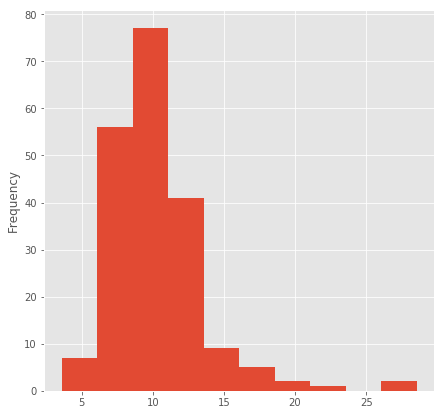

In [345]:
wg_stat['wg_std'].plot.hist(figsize=[7,7])

In [347]:
wg_stat[wg_stat['wg_std'] > 10]

,wg_mean,wg_std
RegistrationCode,,
12752,98.932977,18.322500
130279,99.871603,11.034922
133828,118.095904,11.371013
142162,92.930310,12.095420
143892,90.167782,10.084830
...,...,...
967551,81.933981,10.114686
972181,86.475874,11.630733
979162,84.671453,12.347297


Maybe it is good to take people who show big difference in the wake up glucose values instead of taking people with high wg_mean, or maybe I should consider both filters?

**Sanity check**  
Let's make sure that people with the highest average wg are also with the highest blood tested fasting glucose

In [349]:
blood_tests_means = calc_mean_per_person(blood_tests)

In [350]:
blood_tests_means.columns

Index(['bt__albumin', 'bt__basophils_%', 'bt__creatinine', 'bt__hemoglobin',
       'bt__mean_platelet_volume', 'bt__hba1c', 'bt__wbc', 'bt__crp_synthetic',
       'bt__ast_got', 'bt__mcv', 'bt__total_cholesterol', 'bt__monocytes_%',
       'bt__crp_hs', 'bt__fructosamine', 'bt__rbc', 'bt__lymphocytes_%',
       'bt__hct', 'bt__ldl_cholesterol', 'bt__triglycerides', 'bt__mch',
       'bt__hdl_cholesterol', 'bt__insulin', 'bt__rdw', 'bt__mchc', 'bt__tsh',
       'bt__platelets', 'bt__neutrophils_%', 'bt__eosinophils_%',
       'bt__alt_gpt', 'bt__glucose'],
      dtype='object')

In [358]:
high_fg_rcs = blood_tests_means[blood_tests_means['bt__glucose'] > 118].index

In [360]:
wg_stat[wg_stat['wg_mean'] > 100].index.nunique()

60

In [383]:
high_wg_rcs = wg_stat[wg_stat['wg_mean'] > 100].index

In [384]:
print(len(high_fg_rcs), len(high_wg_rcs))

66 60


In [385]:
print(set(high_wg_rcs).difference(set(high_fg_rcs)))

{'910720', '168236', '932700', '476133', '533401', '631485', '885039', '869485', '981727', '625103', '81477', '287239', '800808', '158747', '621142', '721061', '242185', '784057', '139531', '491836', '825349', '867514', '347571', '479878', '941542', '154750', '997427', '518788', '834851'}


In [386]:
index_to_check = list(set(high_wg_rcs).difference(set(high_fg_rcs)))

Below are blood test values for people who's estimated average wg values are above 100.

In [388]:
blood_tests_means['bt__glucose'].loc[index_to_check]

RegistrationCode
910720    117.400000
168236    112.833333
932700    115.500000
476133    117.142857
533401    116.750000
631485    117.000000
885039    111.800000
869485    114.500000
981727    104.333333
625103    110.200000
81477     110.000000
287239    117.333333
800808    112.199783
158747    105.600000
621142    114.833333
721061    110.833333
242185    116.000000
784057    107.166667
139531    103.142857
491836    114.666667
825349    115.800000
867514    111.166667
347571     98.400000
479878    113.200000
941542    113.400000
154750    115.833333
997427    115.000000
518788    106.000000
834851    107.666667
Name: bt__glucose, dtype: float64

Now I want to look at people who have fasting glucose above 118  but estimated wg less than 100

In [389]:
index_to_check = list(set(high_fg_rcs).difference(set(high_wg_rcs)))
wg_stat['wg_mean'].loc[index_to_check]

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


RegistrationCode
908190    98.518872
326754    96.647506
406329    96.209211
593539          NaN
216303    78.520817
900460    93.179225
363101    92.235686
626391    89.686283
794434    91.331359
433346    90.927266
388245    88.539378
460407          NaN
501757    99.896421
336079    89.513344
347170          NaN
505495          NaN
704171    91.538403
351160    90.075333
279694          NaN
252002    98.353959
87733           NaN
381094    91.076284
831208    99.690524
860991          NaN
322846    96.106568
991569          NaN
143892    90.167782
12752     98.932977
548470          NaN
17298     91.668698
972181    86.475874
439484    94.571343
67951     87.577491
682027    80.155092
880811          NaN
Name: wg_mean, dtype: float64

Those people should be above 117 but they appear to be too low on the wake up glucose according to my estimation

In [412]:
wakeup_glucose.loc['908190'].tail(20)

,wakeup_glucose
Day,
2019-02-26,101.500000
2019-02-27,98.250000
2019-02-28,95.750000
2019-03-01,95.250000
2019-03-02,90.250000
2019-03-03,82.250000
2019-03-06,95.285714
2019-03-07,83.785714
2019-03-08,88.035714


In [392]:
blood_tests.loc['908190']['bt__glucose']

Date
2018-08-09    109.0
2018-10-02    143.0
2018-12-13    143.0
2019-03-12    113.0
2019-06-05    122.0
2019-09-19    115.0
Name: bt__glucose, dtype: float64

### Predict wg for people with highest wg_mean, wg_std

In [395]:
rc_index = wg_stat[wg_stat['wg_mean'] > 100].index

In [403]:
wg_select = wakeup_glucose_trans.reset_index('Day').loc[rc_index].set_index('Day', append=True)

In [404]:
predict_value(wg_select, diet_pers_dat, n_2h_rounds=3, end_loc=-1, max_depth=5)

Round 0 K-fold CV average score: -0.03
Round 1 K-fold CV average score: -0.03
Round 2 K-fold CV average score: -0.04


## Running predictions

In [525]:
X.shape

(23502, 61)

In [542]:
start = 242
X,y = wg_pred_df.iloc[:,start:-1], pd.DataFrame(wg_pred_df.iloc[:,-1])
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=383)

xgbr = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 6, n_estimators = 100) 

xgbr.fit(X_train, y_train)

# kfold = KFold(n_splits=5, shuffle=True)
# kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
# print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

y_pred = xgbr.predict(X_test)
r2_score(y_test, y_pred)

In [95]:
pers_data.shape

(226, 39)

In [98]:
wg_pred_df.iloc[:,242:-40]

(22, weight)  (22, caffeine_mg)  \
RegistrationCode Day                                           
111527           2017-11-08    -20.593949          -4.891538   
                 2017-11-10    -20.593949          -4.891538   
                 2017-11-11    -20.593949          -4.891538   
                 2017-11-12    -20.593949          -4.891538   
                 2017-11-13    -20.593949          -4.891538   
...                                   ...                ...   
997735           2019-07-18    117.707568          12.850811   
                 2019-07-19    -27.292432          -1.349189   
                 2019-07-20    -27.292432          -1.349189   
                 2019-07-21    -27.292432          -1.349189   
                 2019-11-03    -27.292432          -1.349189   

                             (22, carbohydrate_g)  (22, energy_kcal)  \
RegistrationCode Day                                                   
111527           2017-11-08             -1.630067         -24.196114   
                 2017-11-10             -1.630067         -24.196114   
                 2017-11-11             -1.630067         -24.196114   
                 2017-11-12             -1.630067         -24.196114   
                 2017-11-13             -1.630067         -24.196114   
...                                           ...                ...   
997735           2019-07-18             12.402066         191.298667   
                 2019-07-19             -3.314934         -48.751333   
                 2019-07-20             -3.314934         -48.751333   
                 2019-07-21             -3.314934         -48.751333   
                 2019-11-03             -3.314934         -48.751333   

                             (22, protein_g)  (22, sodium_mg)  \
RegistrationCode Day                                            
111527           2017-11-08        -0.847164       -22.907590   
                 2017-11-10        -0.847164       -22.907590   
                 2017-11-11        -0.847164       -22.907590   
                 2017-11-12        -0.847164       -22.907590   
                 2017-11-13        -0.847164       -22.907590   
...                                      ...              ...   
997735           2019-07-18         5.666681        62.867715   
                 2019-07-19        -1.533319       -44.283885   
                 2019-07-20        -1.533319       -44.283885   
                 2019-07-21        -1.533319       -44.283885   
                 2019-11-03        -1.533319       -44.283885   

                             (22, sugarstotal_g)  (22, totaldietaryfiber_g)  \
RegistrationCode Day                                                          
111527           2017-11-08            -0.300153                  -0.114151   
                 2017-11-10            -0.300153                  -0.114151   
                 2017-11-11            -0.300153                  -0.114151   
                 2017-11-12            -0.300153                  -0.114151   
                 2017-11-13            -0.300153                  -0.114151   
...                                          ...                        ...   
997735           2019-07-18            -0.871429                   0.223823   
                 2019-07-19            -0.871429                  -0.534177   
                 2019-07-20            -0.871429                  -0.534177   
                 2019-07-21            -0.871429                  -0.534177   
                 2019-11-03            -0.871429                  -0.534177   

                             (22, totallipid_g)  (22, caloric%carbs)  ...  \
RegistrationCode Day                                                  ...   
111527           2017-11-08           -1.593500            -0.030380  ...   
                 2017-11-10           -1.593500            -0.030380  ...   
                 2017-11-11           -1.593500            -0.030380  ...   


In [142]:
# Predicting wakeup glucose
start = 242

for i in range(1):
    start = 242 - 22*i
    X,y = wg_pred_df.iloc[:,start:-1], pd.DataFrame(wg_pred_df.iloc[:,-1])
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=383)
    xgbr = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 4, n_estimators = 100) 

    xgbr.fit(X_train, y_train)

    kfold = KFold(n_splits=3, shuffle=True)
    kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
    print("Round %d K-fold CV average score: %.2f" % (i, kf_cv_scores.mean()))

Round 0 K-fold CV average score: 0.45


In [128]:
y_pred = xgbr.predict(X_test)
r2_score(y_test, y_pred)

0.44591688521023864

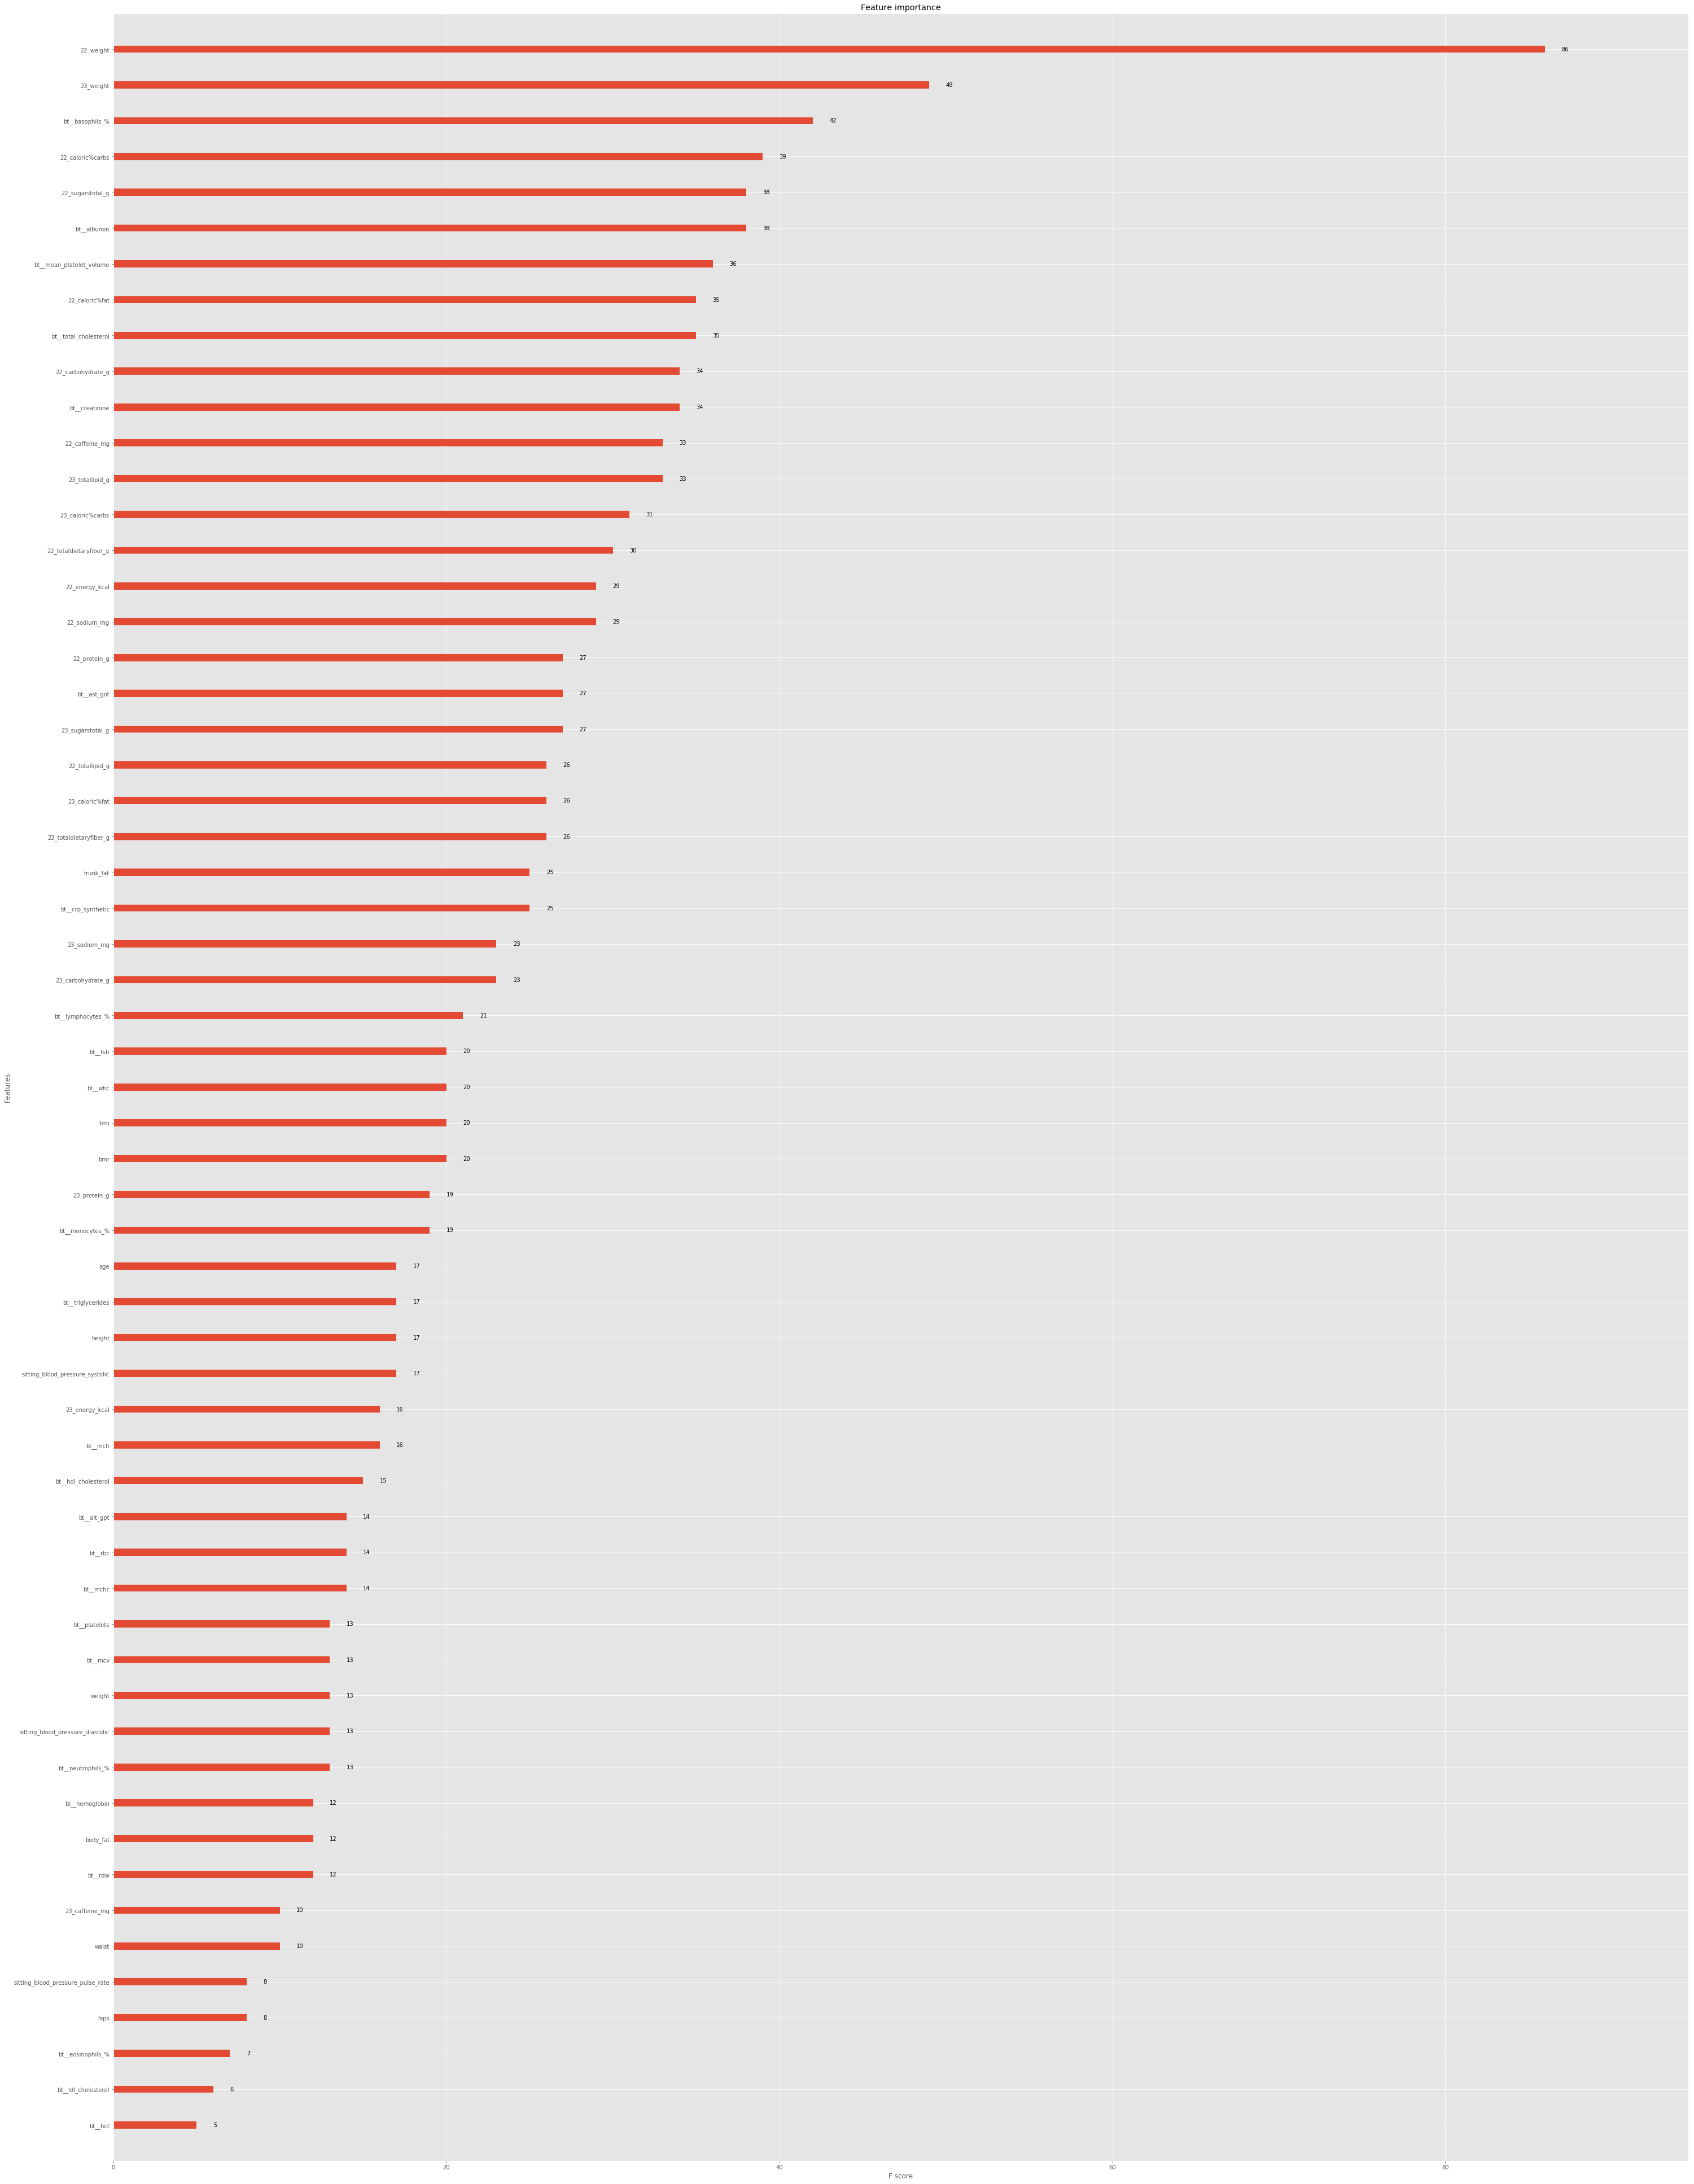

In [143]:
xgb.plot_importance(xgbr)
plt.rcParams['figure.figsize'] = [10, 20]

Text(0.5,1,'Prediction of the wakeup glucose, PNP3')

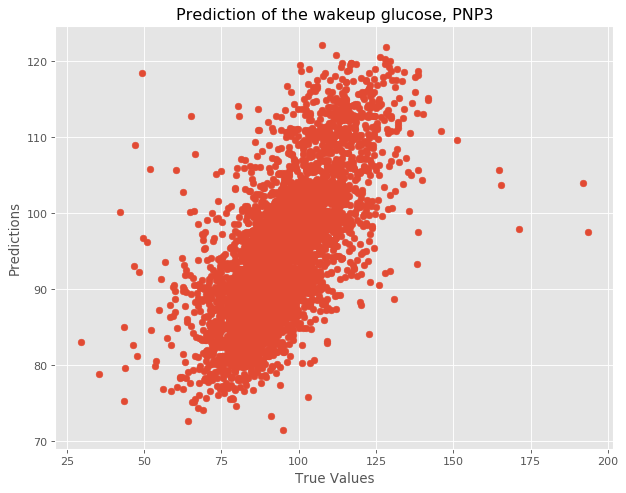

In [144]:
plt.figure(figsize=(9, 7), dpi=80)
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Prediction of the wakeup glucose, PNP3')

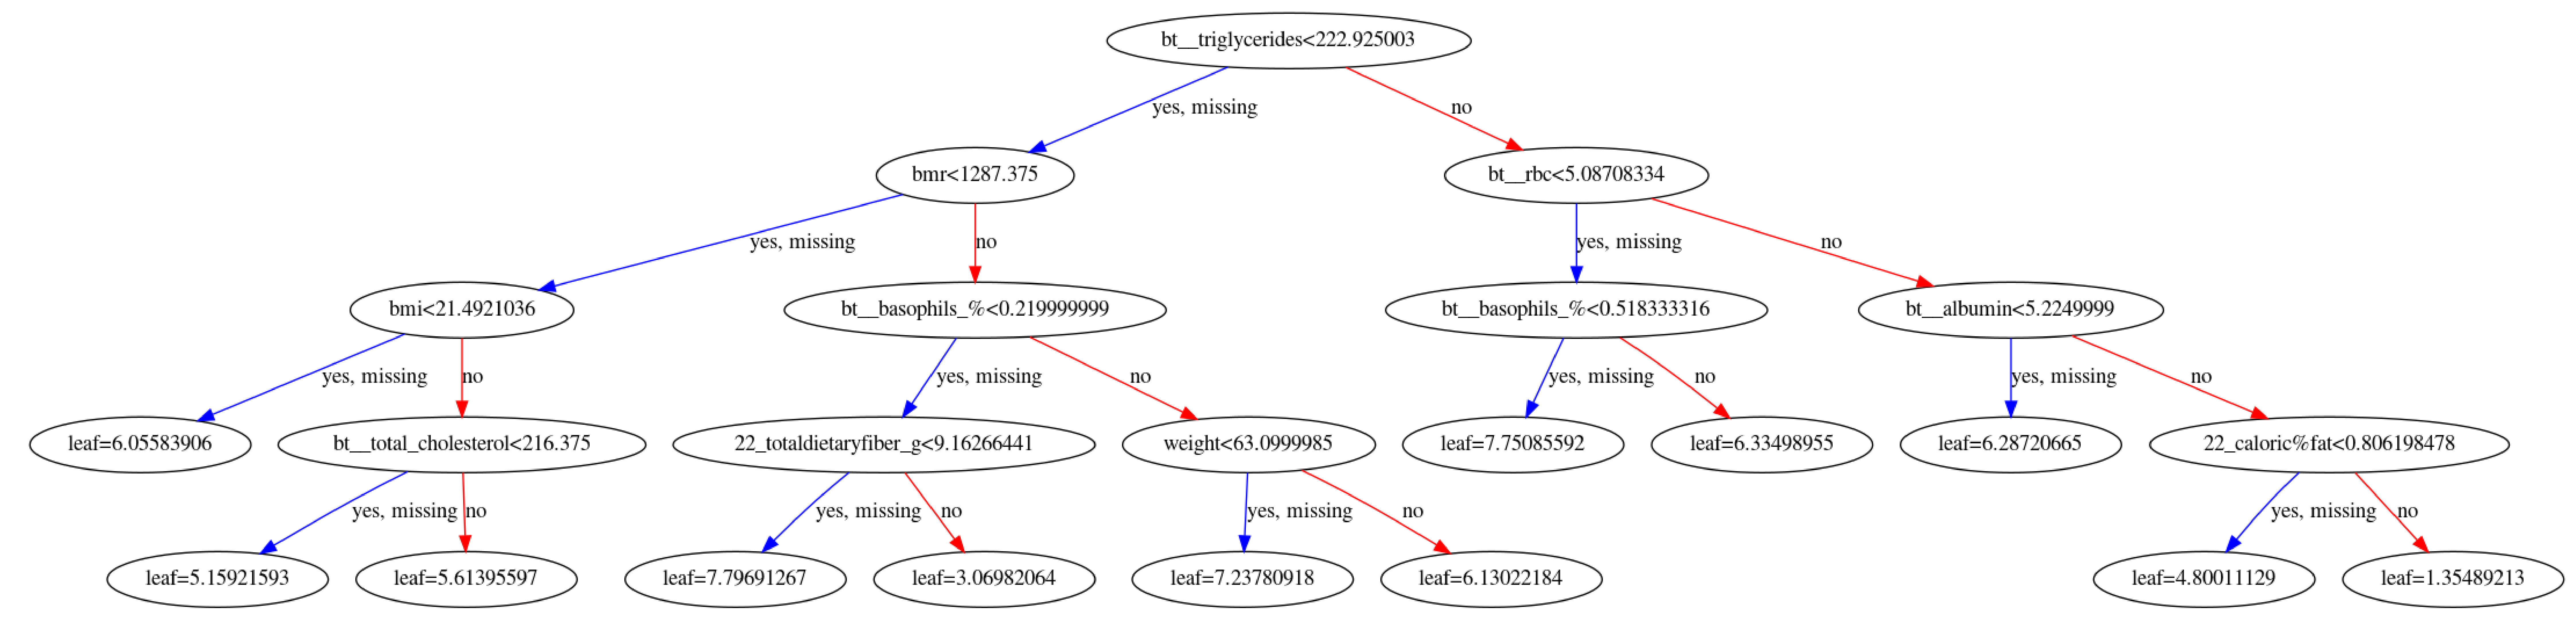

In [158]:
fig = plt.figure(dpi=180)
ax = plt.subplot(1,1,1)
xgb.plot_tree(xgbr, num_trees=4, ax=ax)
plt.tight_layout()
# plt.savefig("tree_structure.png")
plt.show()

In [83]:
# Predicting CV
start = 242

for i in range(5):
    start = 242 - 22*i
    X,y = cv_pred_df.iloc[:,start:-1], pd.DataFrame(cv_pred_df.iloc[:,-1])
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=383)
    xgbr = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 5, n_estimators = 100) 

    xgbr.fit(X_train, y_train)

    kfold = KFold(n_splits=3, shuffle=True)
    kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
    print("Round %d K-fold CV average score: %.2f" % (i, kf_cv_scores.mean()))

Round 0 K-fold CV average score: 0.17
Round 1 K-fold CV average score: 0.19
Round 2 K-fold CV average score: 0.18
Round 3 K-fold CV average score: 0.19
Round 4 K-fold CV average score: 0.18
Round 5 K-fold CV average score: 0.18
Round 6 K-fold CV average score: 0.18
Round 7 K-fold CV average score: 0.18


In [131]:
X.head()

18_weight  18_caffeine_mg  18_carbohydrate_g  \
RegistrationCode Day                                                         
111527           2017-11-08  -68.407641      -11.724513          -4.574317   
                 2017-11-10  407.602359      100.775487          10.693683   
                 2017-11-11  540.192359      -11.724513          99.912208   
                 2017-11-12  -68.407641      -11.724513          -4.574317   
                 2017-11-13  -68.407641      -11.724513          -4.574317   

                             18_energy_kcal  18_protein_g  18_sodium_mg  \
RegistrationCode Day                                                      
111527           2017-11-08      -79.596534     -3.815951   -115.507092   
                 2017-11-10      337.833466     16.819049    509.492908   
                 2017-11-11      644.786115     21.158966    813.786575   
                 2017-11-12      -79.596534     -3.815951   -115.507092   
                 2017-11-13      -79.596534     -3.815951   -115.507092   

                             18_sugarstotal_g  18_totaldietaryfiber_g  \
RegistrationCode Day                                                    
111527           2017-11-08         -0.427299               -0.517054   
                 2017-11-10         -0.112859                2.101046   
                 2017-11-11         -0.269299                1.244221   
                 2017-11-12         -0.427299               -0.517054   
                 2017-11-13         -0.427299               -0.517054   

                             18_totallipid_g  18_caloric%carbs  ...  \
RegistrationCode Day                                            ...   
111527           2017-11-08        -5.043453         -0.071544  ...   
                 2017-11-10        25.196547          0.074761  ...   
                 2017-11-11        15.862102          0.505424  ...   
                 2017-11-12        -5.043453         -0.071544  ...   
                 2017-11-13        -5.043453         -0.071544  ...   

                                 height  bt__albumin  bt__basophils_%  \
RegistrationCode Day                                                    
111527           2017-11-08  152.444444     4.766667             0.35   
                 2017-11-10  152.444444     4.766667             0.35   
                 2017-11-11  152.444444     4.766667             0.35   
                 2017-11-12  152.444444     4.766667             0.35   
                 2017-11-13  152.444444     4.766667             0.35   

                             bt__creatinine  bt__hemoglobin  \
RegistrationCode Day                                          
111527           2017-11-08        0.666667       12.583333   
                 2017-11-10        0.666667       12.583333   
                 2017-11-11        0.666667       12.583333   
                 2017-11-12        0.666667       12.583333   
                 2017-11-13        0.666667       12.583333   

                             bt__mean_platelet_volume   bt__wbc  \
RegistrationCode Day                                              
111527           2017-11-08                       8.0  7.216667   
                 2017-11-10                       8.0  7.216667   
                 2017-11-11                       8.0  7.216667   
                 2017-11-12                       8.0  7.216667   
                 2017-11-13                       8.0  7.216667   

                             bt__crp_synthetic  bt__ast_got  bt__mcv  
RegistrationCode Day                                                  
111527           2017-11-08           1.766526         23.0     82.0  
                 2017-11-10           1.766526         23.0     82.0  
                 2017-11-11           1.766526         23.0     82.0  
                 2017-11-12           1.766526         23.0     82.0  
                 2017-11-13           1.766526         23.0     82.0  

[5 rows x 86 columns]

In [553]:
xgbr = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 5, n_estimators = 100) 

xgbr.fit(X_train, y_train)

kfold = KFold(n_splits=3, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

y_pred = xgbr.predict(X_test)
r2_score(y_test, y_pred)

K-fold CV average score: 0.19


0.20970332986250306

Text(0.5,1,'Prediction of the CV of the night, PNP3')

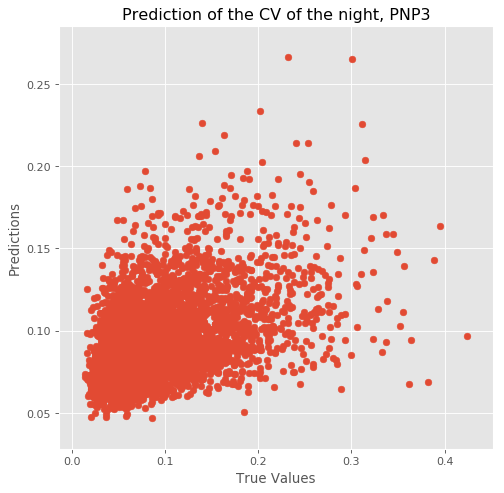

In [561]:
plt.figure(figsize=(7, 7), dpi=80)
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Prediction of the CV of the night, PNP3')

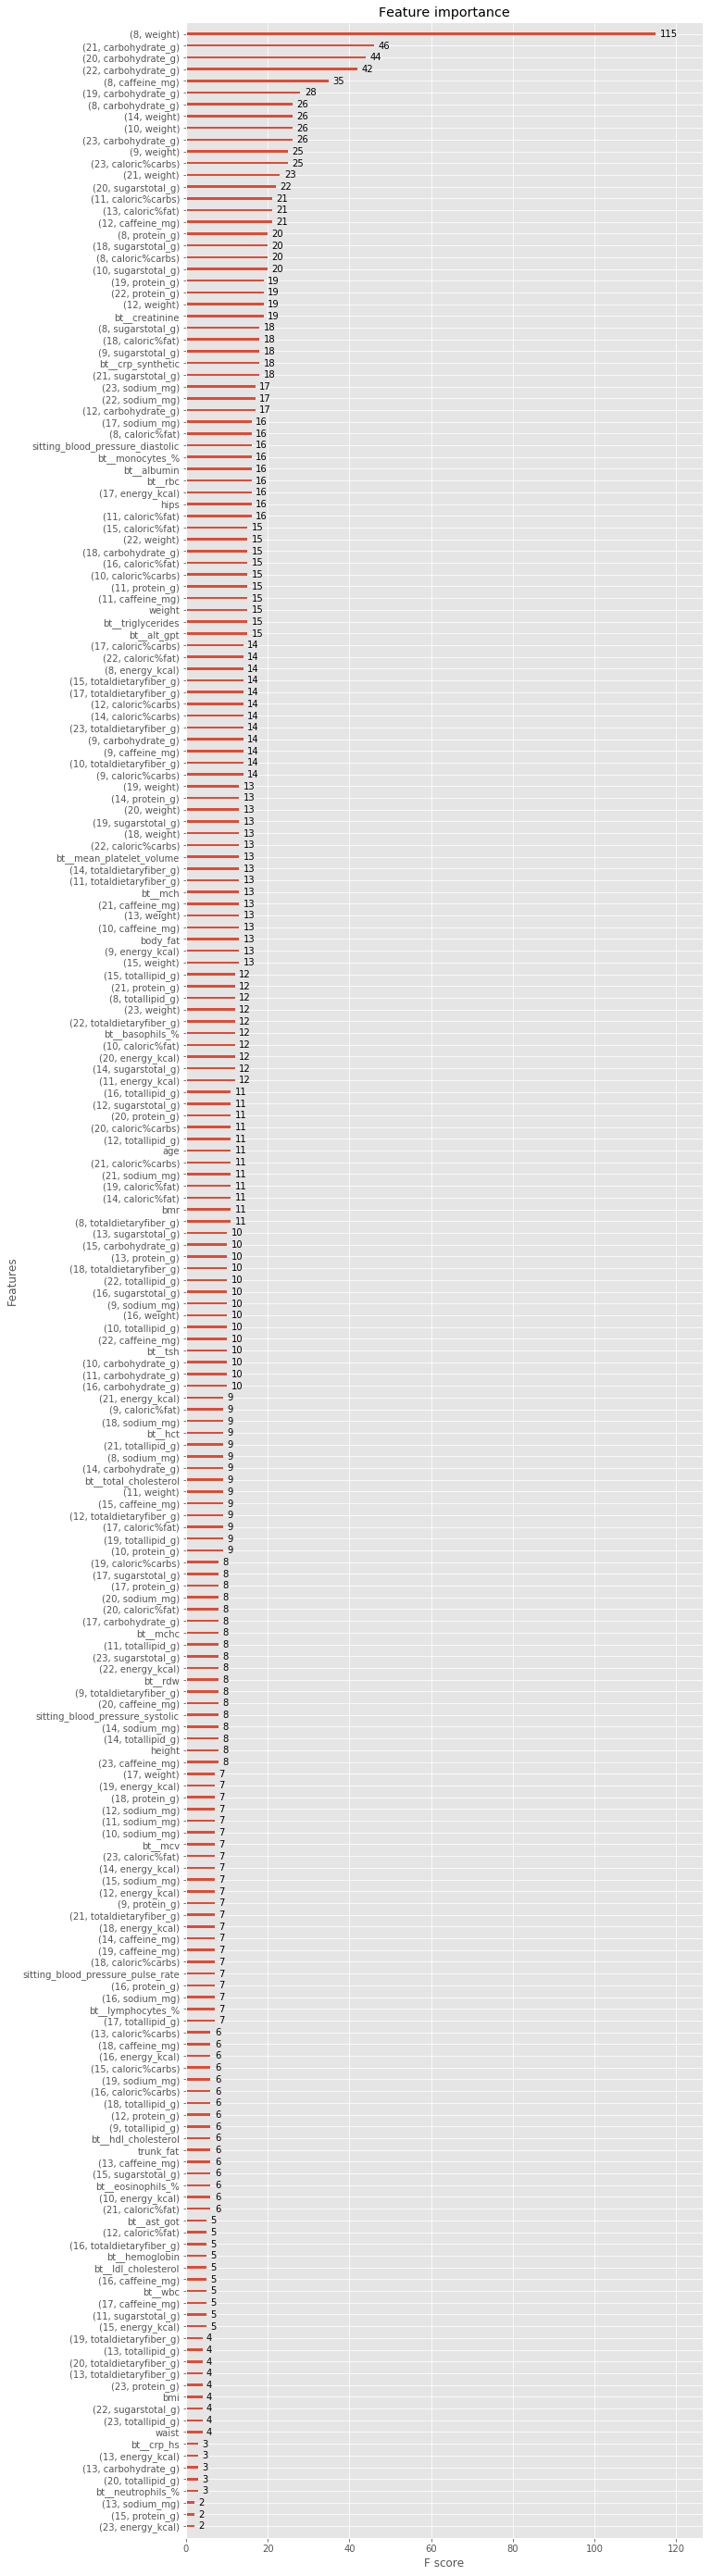

In [577]:
xgb.plot_importance(xgbr)
plt.rcParams['figure.figsize'] = [10, 30]

In [517]:
xgbr = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, colsample_bytree = 0.8,
                max_depth = 100, alpha = 10, n_estimators = 100) 

xgbr.fit(X_train, y_train)

# kfold = KFold(n_splits=5, shuffle=True)
# kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
# print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

y_pred = xgbr.predict(X_test)
r2_score(y_test, y_pred)

-0.06015935907001868

In [514]:
print(xgbr)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)


In [ ]:




 
# - cross validataion 
# scores = cross_val_score(xgbr, X_train, y_train, cv=3)
# print("Mean cross-validation score: %.2f" % scores.mean())


 
y_pred = xgbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))

r2_score(y_test, y_pred)

xgb.plot_importance(xgbr)
plt.rcParams['figure.figsize'] = [10, 6]

In [270]:
wg_mean[wg_mean['wakeup_glucose'] < 85]

,wakeup_glucose
RegistrationCode,
126092,80.000718
132095,80.954615
173854,82.343803
216303,78.520817
243235,76.991305
246043,83.392575
356171,83.231330
356392,83.801531
371755,77.385469


In [268]:
60*150

9000